---
# This notebook deals with the part of training the conditional GAN that requires the real voxel measurement from brain data.

#### Notes: If we used a high-resolution image set (for the training of the GAN), we could train the encoding model with hi-rez images and still use a lower-rez version for the training of the GAN. In this version, all images are downsampled to the resolution of cifar-10. This incurs a large reduction in prediction accuracy for the encoding model.
---

In [1]:
import sys
import os
import struct
import time
import numpy as np
import h5py
import scipy.io as sio
from scipy import ndimage as nd
from scipy import misc
from tqdm import tqdm
import pickle
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import PIL.Image as pim
import seaborn as sns
%matplotlib inline

import theano
import theano.tensor as T

import lasagne
import lasagne.layers as L
import lasagne.regularization as R
import lasagne.nonlinearities as NL
import lasagne.objectives as O
import lasagne.init as I

import src.fwrf as fwrf
import src.numpy_utility as pnu
import src.lasagne_utility as plu
from src.load_data import load_stimuli, load_voxels

Using cuDNN version 5103 on context None
Mapped name None to device cuda0: GeForce GTX TITAN X (0000:05:00.0)

theano floatX: float32
numpy floatX: <type 'numpy.float32'>


In [2]:
fpX = np.float32
print "theano floatX: %s" % theano.config.floatX
print "numpy floatX: %s" % fpX

sns.axes_style()
sns.set_style("whitegrid", {"axes.facecolor": '.95'})
sns.set_context("notebook", rc={'axes.labelsize': 32.0, 'axes.titlesize': 36.0, 'legend.fontsize': 32.0,\
                                'xtick.labelsize': 28.0, 'ytick.labelsize': 28.0})
sns.set_palette("deep")

theano floatX: float32
numpy floatX: <type 'numpy.float32'>


In [3]:
cwd = os.getcwd() + '/'
output_dir  = cwd + "output/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
result_dir  = cwd + "results/"
if not os.path.exists(result_dir):
    os.makedirs(result_dir)    
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime())

print "Current dir: %s" % cwd
print "Time Stamp: %s" % timestamp

Current dir: /home/styvesg/Documents/PostDoc/GitRepo/gan-imaging-clean/
Time Stamp: Aug-19-2019_1823


In [4]:
saveext = ".pdf"
savearg = {'format':'pdf', 'dpi': 200}

# 1) Load the image and corresponding voxel dataset
### Images
Let's call these images 'stims' since they are the actual stimulus presented to the viewer. The other images will be called 'images' and will be used to generate the synthetic training set for the GAN

In [5]:
dataset_dir = "/home/styvesg/Documents/PostDoc/Datasets/vim-1/"

In [6]:
npc = 3         # # of channels in image
npx = 32        # # of pixels width/height of images 
nx = npx*npx*npc   # # of dimensions in X
ny = 10   # # of classes

In [7]:
_, stim_data, stim_trn_size = load_stimuli(dataset_dir, npx=npx, npc=npc)

stim_data_size = len(stim_data)
stim_val_size = stim_data_size - stim_trn_size

stim_data -= 0.5
trn_stim_data = stim_data[:stim_trn_size]
val_stim_data = stim_data[stim_trn_size:]

trn: 1750, val: 120
Data shape = (1870, 3, 32, 32)


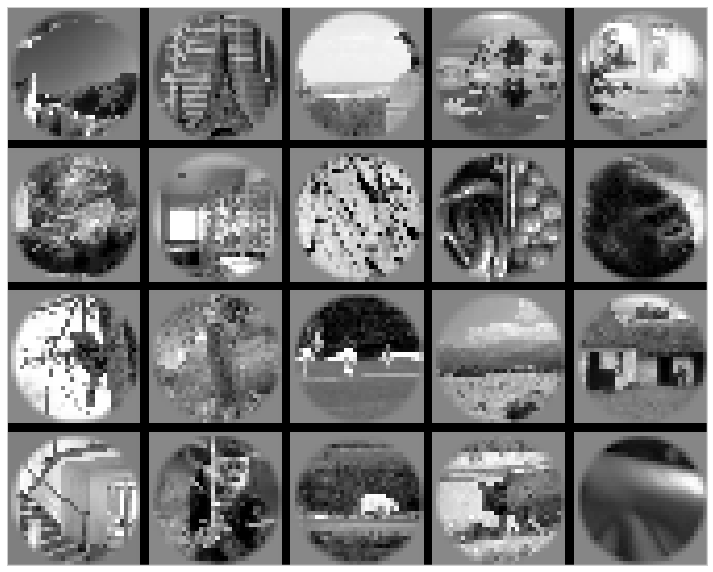

In [8]:
fig=plt.figure(figsize=(16,10))
plt.imshow(pnu.mosaic_vis(stim_data[-20:,...].transpose(0,2,3,1), pad=2), interpolation='None')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

In [10]:
filename = result_dir + "stimuli_samples"
fig.patch.set_alpha(0.)
fig.savefig(filename + saveext, **savearg)
plt.close()

### Voxel data
voxel data is associated one-to-one with stims data

In [9]:
subject = 'S1'

roi_names = ['V1', 'V2', 'V3', 'V4', 'LO', 'V3a/b', 'other']
roi_group = [[1], [2], [3], [6], [7], [4,5], [0]]
marker_list    = ['o', 's', '^', 'D', 'v', '<', '>', '*', 'x']
roi_markers    = {name: marker_list[k] for k,name in enumerate(roi_names)}
roi_colors = {name: sns.color_palette("deep", len(roi_names))[k] for k,name in enumerate(roi_names)}

def iterate_roi(group, voxelroi, names):
    for n,g in zip(names, group):
        mask = np.zeros(shape=voxelroi.shape, dtype=bool)
        for i,roi in enumerate(g):
            mask = np.logical_or(mask, voxelroi==roi)
        yield mask, n   

In [10]:
voxel_data, voxel_roi, voxel_idx = load_voxels(dataset_dir, subject)

nv = voxel_data.shape[1]
print "nv = %d" % nv

trn_voxel_data = voxel_data[:stim_trn_size]
val_voxel_data = voxel_data[stim_trn_size:]

22701 of 25915 voxels contain valid values for all images
nv = 22701


In [11]:
for roi, value  in enumerate(iterate_roi(roi_group, voxel_roi.flatten(), roi_names)):         
    roi_mask, name = value
    print "%s: %d" % (name, np.sum(roi_mask))

V1: 1294
V2: 2083
V3: 1790
V4: 1535
LO: 928
V3a/b: 798
other: 14273


# 2) Reload the classifier net (as part of the voxel encoding model)

This may not be entirely necessary. There are dozens of trained classification networks out there and we don't need this net to be of the same input size or trained on the same set as we would the GAN

In [12]:
from net.cifar10_definitions import cls_net, cls_net_str

_X = T.tensor4()
_Y = T.matrix()

cls_input = L.InputLayer(shape=(None, npc, npx, npx), input_var=_X, name='X')
aux, cls = cls_net(cls_input)

plu.print_lasagne_network(cls, skipnoparam=True)
print cls_net_str

Layer	: <lasagne.layers.input.InputLayer object at 0x7fd38a108cd0>
Name	: X
Type	: <class 'lasagne.layers.input.InputLayer'>
Shape	: (None, 3, 32, 32)


Layer	: <lasagne.layers.conv.Conv2DLayer object at 0x7fd38a108690>
Name	: None
Type	: <class 'lasagne.layers.conv.Conv2DLayer'>
Shape	: (None, 128, 16, 16)
Params
        |-- W         : (128, 3, 4, 4)
        |-- b         : (128,)


Layer	: <lasagne.layers.conv.Conv2DLayer object at 0x7fd38a0ba410>
Name	: None
Type	: <class 'lasagne.layers.conv.Conv2DLayer'>
Shape	: (None, 256, 8, 8)
Params
        |-- W         : (256, 128, 4, 4)


Layer	: <lasagne.layers.normalization.BatchNormLayer object at 0x7fd3b7c5e790>
Name	: None
Type	: <class 'lasagne.layers.normalization.BatchNormLayer'>
Shape	: (None, 256, 8, 8)
Params
        |-- mean      : (256,)
        |-- inv_std   : (256,)


Layer	: <lasagne.layers.conv.Conv2DLayer object at 0x7fd38a0cb090>
Name	: None
Type	: <class 'lasagne.layers.conv.Conv2DLayer'>
Shape	: (None, 384, 6, 6)
Param

In [13]:
cls_params = L.get_all_params(cls, trainable=True)
print cls_params

_cls_val_pred = L.get_output(cls, deterministic=True)
_class = T.extra_ops.to_one_hot(T.argmax(_cls_val_pred, axis=1), ny)
_fmaps = [L.get_output(a, deterministic=True) for a in aux]

print 'COMPILING'
t = time.time()
cls_pred_fn = theano.function([_X], _fmaps+[_class,])
print '%.2f seconds to compile theano functions'%(time.time()-t)

[W, b, W, W, W, W, W, b]
COMPILING
4.52 seconds to compile theano functions


In [14]:
cls_param_file = open(output_dir + "cifar10-cls-128c4s2_256c4s2_384c3_512c3_1024c1_gp_10f-Aug-23-2017_1628.pkl", 'rb')
cls_param_value = pickle.load(cls_param_file)
cls_param_file.close()

L.set_all_param_values(cls, cls_param_value)  

In [15]:
# this is just to get an instance for the shape of the feature maps
sample_size = 1
inf = cls_pred_fn(stim_data[stim_trn_size:stim_trn_size+sample_size,...])
inf_fmaps, inf_Y = inf[:-1], inf[-1]

/usr/local/lib/python2.7/dist-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


# 3) fwRF model definition and training
## Define the input

In [16]:
model_name = cls_net_str

_invar = [_X,]
invar_sizes = [(1, npc, npx, npx),]

_fmaps      = [L.get_output(a, deterministic=True) for a in aux]
fmaps_sizes = [f.shape for f in inf_fmaps]
fmaps_res_count = len(fmaps_sizes)
fmaps_count = np.sum([f.shape[1] for f in inf_fmaps])
nf          = fmaps_count # alias

---
## Define the search parameters

In [17]:
lx = ly = 1. # 1 stimuli per stimuli
nx = ny = 15
smin, smax = 0.035, 0.40
ns = 8

# sharedModel specification is a list of 3 ranges and 3 callable functor. The reason for this is for a future implementation of dynamic mesh refinement.
model_specs = [[(0., lx*1.1), (0., ly*1.1), (smin, smax)], [fwrf.linspace(nx), fwrf.linspace(ny), fwrf.logspace(ns)]]
models = fwrf.model_space(model_specs)
print models.shape

(1800, 3)


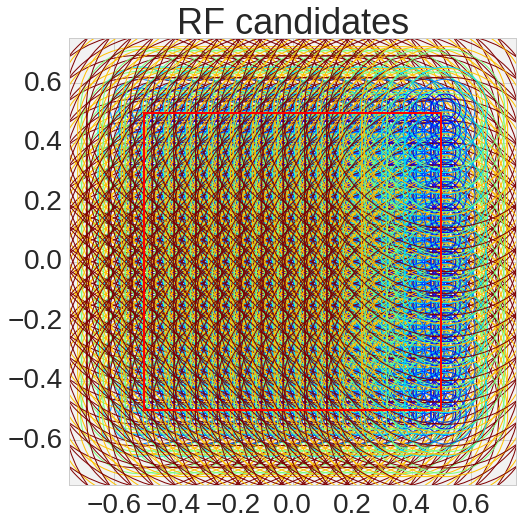

In [18]:
from matplotlib.patches import Ellipse
import matplotlib.colors as colors
import matplotlib.cm as cmx

vx = 1.5
cNorm  = colors.Normalize(vmin=.0, vmax=.4)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=plt.get_cmap('jet') )

plt.figure(figsize=(8, 8))
ax = plt.gca()
for x,y,s in models:
    ax.add_artist(Ellipse(xy=(x,y), width=2*s, height=2*s, angle=0,
        color=scalarMap.to_rgba(s), lw=1, fill=False))
ax.set_xlim(-vx/2, vx/2)
ax.set_ylim(-vx/2, vx/2)
ax.set_aspect('equal')
plt.plot([-lx/2,lx/2,lx/2,-lx/2,-lx/2], [lx/2,lx/2,-lx/2,-lx/2, lx/2], 'r', lw=2)   
plt.title('RF candidates')

## Define the model

In [19]:
sample_batch_size = 200

log_act_func = lambda x: np.log(fpX(1)+np.sqrt(np.abs(x)))
_log_act_func = lambda _x: T.log(fpX(1)+T.sqrt(T.abs_(_x)))

all_mst_data, all_mst_avg, all_mst_std = fwrf.model_space_tensor([stim_data], models,\
            _symbolic_feature_maps=_fmaps, fmaps_sizes=fmaps_sizes, _symbolic_input_vars=_invar, \
            nonlinearity=log_act_func, zscore=True, trn_size=stim_trn_size,\
            epsilon=1e-6, batches=(sample_batch_size, nx*ny), \
            view_angle=lx, verbose=True, dry_run=False)
print all_mst_data.shape

CREATING SYMBOLS

> feature map candidates 0 with shape (1, 225, 16, 16)
> feature map candidates 1 with shape (1, 225, 8, 8)
> feature map candidates 2 with shape (1, 225, 6, 6)
> feature map candidates 3 with shape (1, 225, 4, 4)
> feature map candidates 4 with shape (1, 225, 4, 4)
> feature map candidates 5 with shape (1, 225, 1, 1)
  total number of feature maps = 2314, in 6 layers
  feature map candidate using approx 0.3 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 29.016Gb of RAM!
>> Will be divided in chunks of 3.627Gb of VRAM!

COMPILING...
1.25 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 8/8 [00:34<00:00,  3.88s/it]

1800 mst candidate responses took 34.115s @ 52.763 models/s
Applying nonlinearity to modelspace tensor...



8it [01:51, 13.92s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



8it [02:36, 19.55s/it]

(1870, 2314, 1, 1800)


In [20]:
print np.amin(all_mst_data), np.amax(all_mst_data)
# split the model space tensor into trn and val set.
trn_mst_data = all_mst_data[:stim_trn_size]
val_mst_data = all_mst_data[stim_trn_size:]

-33.770695 45.649666


In [21]:
voxel_batch_size = 500
holdout_size = 350
lambdas = np.logspace(2.5,6.5,12)

# parallelized batched ridge regression
best_scores, best_lambdas, best_candidates, best_w_params = \
    fwrf.learn_params_ridge_regression(trn_mst_data, trn_voxel_data, lambdas, voxel_batch_size, holdout_size, True, True)
    
best_rf_params, best_avg, best_std = fwrf.real_space_model(\
                best_candidates, models, mst_avg=all_mst_avg, mst_std=all_mst_std) 

COMPILING
2.06 seconds to compile theano functions

100%|██████████| 1800/1800 [4:28:15<00:00,  8.82s/it]


-------------------------
total time = 16095.729473s
total throughput = 0.709032s/voxel
voxel throughput = 0.313209s/voxel
setup throughput = 4.991986s/candidate


[3.16227766e+02 7.30527154e+02 1.68761248e+03 3.89860370e+03
 9.00628020e+03 2.08056754e+04 4.80638086e+04 1.11033632e+05
 2.56502091e+05 5.92553098e+05 1.36887451e+06 3.16227766e+06]


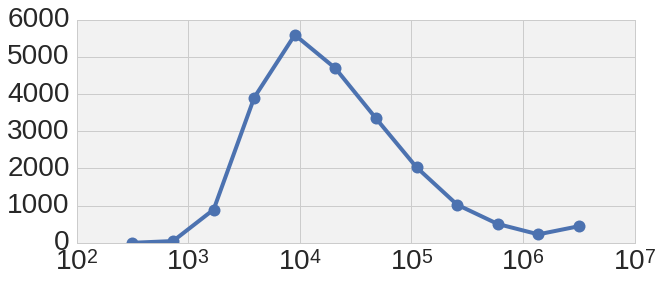

In [22]:
plt.figure(figsize=(10,4))
print lambdas
plt.plot(lambdas, [np.sum(best_lambdas==k) for k in range(len(lambdas))], lw=4, marker='o', ms=12)
plt.xscale('log')

In [23]:
val_pred = fwrf.get_prediction_from_mst(val_mst_data, best_candidates, best_w_params, batches=(500, ny*nx))
val_cc = np.zeros(shape=(nv,), dtype=fpX)    
for v in tqdm(range(nv)):    
    val_cc[v] = np.corrcoef(val_pred[:,v], val_voxel_data[:,v])[0,1]

100%|██████████| 22701/22701 [00:01<00:00, 18342.25it/s]


In [24]:
project = "gan-imaging"
model_name = "cifar-10-fwrf"

model_values = {'project': project,
         'subject': subject,
         'model_name': model_name,
         'aperture': lx,
         'grid_size': (nx,ny,ns),
         'grid': models,
         'fmaps_res_count': fmaps_res_count,
         'fmaps_count': fmaps_count,
         'fmaps_sizes': fmaps_sizes,
         'voxel_mask': np.ones(len(voxel_idx), dtype=bool),
         'voxel_idx': voxel_idx,
         'voxel_roi': voxel_roi,
         'val_size': stim_val_size,
         'trn_size': stim_trn_size,
         'tho_size': holdout_size,
         'results': {
             'best_lambdas': best_lambdas,
             'best_candidates': best_candidates,
             'rf_params': best_rf_params,
             'w_params': best_w_params,
             'normavg': best_avg,
             'normstd': best_std, 
             'val_pred': val_pred,
             'val_cc': val_cc}
          }

In [25]:
data_file_name = output_dir + "fwrf_%s_%s_%s_data.pkl" % (model_name, subject, timestamp)
data_file = open(data_file_name, 'wb')
pickle.dump(model_values, data_file)
data_file.close()
print data_file_name

/home/styvesg/Documents/PostDoc/GitRepo/gan-imaging-clean/output/fwrf_cifar-10-fwrf_S1_Aug-19-2019_1823_data.pkl


---

In [26]:
from src.file_utility import load_mask_from_nii, view_data

max cc = 0.811021
sum(cc>0.30) = 1532 of 22701


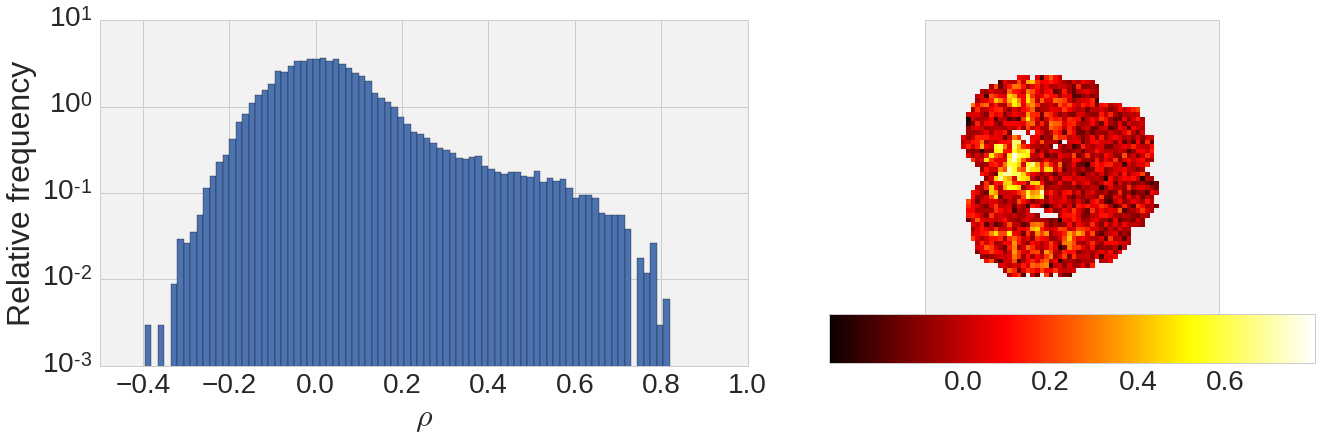

In [27]:
cc_th = 0.3
print "max cc = %f" % np.max(val_cc)
print "sum(cc>%.2f) = %d of %d" % (cc_th, np.sum(map(lambda x: x > cc_th, val_cc)), nv)
volume_cc = view_data((64, 64, 18), voxel_idx, val_cc, order='F', save_to=result_dir + "%s_val_cc_%s.nii" % (model_name, timestamp))

fig=plt.figure(figsize=(18,6))
plt.subplots_adjust(left=0., bottom=0.2, right=1., top=1., wspace=0., hspace=0.)
plt.subplot(1,2,1)
_=plt.hist(val_cc, bins=100, normed=True, range=(-.5, 1.))
plt.yscale('log')
#plt.ylim([10**-1, 10**1])
plt.xlim([-.5, 1.])
plt.xlabel(r'$\rho$')
plt.ylabel('Relative frequency')
#
plt.subplot(1,2,2)
plt.imshow(volume_cc[:,:,10], cmap='hot', interpolation='None')
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.grid('off')
plt.colorbar(aspect=10, shrink=.75, ticks=[0, .2, .4, .6], orientation='horizontal', pad=0)
plt.xticks([])
plt.yticks([])

fig.savefig(result_dir + "%s_val_cc_%s.png" % (model_name, timestamp))

## Calculate tuning

In [28]:
#find the start and end point of the feature map partitions
fmaps_count = len(fmaps_sizes)
partitions = [0,]
for r in fmaps_sizes:
    partitions += [partitions[-1]+r[1],]
print partitions

[0, 128, 384, 768, 1280, 2304, 2314]


In [29]:
partition_val_pred = np.ndarray(shape=(fmaps_count,)+val_pred.shape, dtype=fpX)
partition_val_cc   = np.ndarray(shape=(fmaps_count,)+val_cc.shape, dtype=fpX)

for l in range(fmaps_count):
    partition_params = [np.zeros(p.shape, dtype=fpX) for p in best_w_params]  
    partition_params[0][:, partitions[l]:partitions[l+1]] = best_w_params[0][:, partitions[l]:partitions[l+1]]
    partition_params[1][:] = best_w_params[1][:]
    partition_val_pred[l,...] = fwrf.get_prediction_from_mst(val_mst_data, best_candidates, partition_params, batches=(500, ny*nx))
    for v in tqdm(range(nv)):    
        partition_val_cc[l,v] = np.corrcoef(partition_val_pred[l,:,v], val_voxel_data[:,v])[0,1]

100%|██████████| 22701/22701 [00:01<00:00, 18181.16it/s]


In [30]:
# calculate covariances
partition_r = np.ndarray(shape=(fmaps_count, nv))
for v in range(nv):
    full_c = np.cov(val_pred[:,v], val_voxel_data[:,v])
    for l in range(fmaps_count):
        part_c = np.cov(partition_val_pred[l,:,v], val_voxel_data[:,v])
        partition_r[l,v] = part_c[0,1]/np.sqrt(full_c[0,0]*full_c[1,1])

In [31]:
part_file = open(output_dir + "fwrf_%s_%s_%s_part.pkl" % (model_name, subject, timestamp), 'wb')
part_values = {'dataset': 'vim-1',
             'subject': subject,
             'model_name': model_name,
             'val_cc': partition_val_cc,
             'val_ri': partition_r}
pickle.dump(part_values, part_file)
part_file.close()

In [32]:
m_data_dict = model_values
m_part_dict = part_values

---
# A few illustrative plots of the model

## Reload fwrf values

In [137]:
#m_file_name = 'fwrf_cifar-10-fwrf_S1_Sep-30-2017_1505_data'
m_data_name = 'fwrf_cifar-10-fwrf_S1_Aug-17-2019_2214_data'
m_part_name = 'fwrf_cifar-10-fwrf_S1_Aug-17-2019_2214_part'

data_file = open(output_dir + "%s.pkl" % m_data_name, 'rb')
m_data_dict = pickle.load(data_file)
data_file.close()

part_file = open(output_dir + "%s.pkl" % m_part_name, 'rb')
m_part_dict = pickle.load(part_file)
part_file.close()

print m_data_dict['model_name']
print m_data_dict.keys()
print m_data_dict['results'].keys()

print m_part_dict.keys()

cifar-10-fwrf
['tho_size', 'fmaps_res_count', 'grid_size', 'project', 'voxel_roi', 'fmaps_count', 'voxel_mask', 'voxel_idx', 'trn_size', 'val_size', 'grid', 'aperture', 'results', 'subject', 'model_name', 'fmaps_sizes']
['rf_params', 'w_params', 'normstd', 'best_lambdas', 'normavg', 'val_pred', 'best_candidates', 'val_cc']
['val_ri', 'dataset', 'val_cc', 'model_name', 'subject']


In [33]:
val_ri = m_part_dict['val_ri']
val_cc = m_data_dict['results']['val_cc']

fmaps_count = m_data_dict['fmaps_res_count']
nROI = len(roi_names)
partition_R_avg = np.ndarray(shape=(fmaps_count, nROI), dtype=fpX)
partition_R_std = np.ndarray(shape=(fmaps_count, nROI), dtype=fpX)
for roi, value  in enumerate(iterate_roi(roi_group, voxel_roi.flatten(), roi_names)):         
    roi_mask, name = value
    mask = np.logical_and(roi_mask, val_cc>0.2)
    for l in range(fmaps_count):
        tuning = val_ri[l, mask] / val_cc[mask]#/  np.sum(val_ri[:,mask], axis=0)
        partition_R_avg[l,roi] = np.mean(tuning)
        partition_R_std[l,roi] = np.std(tuning)

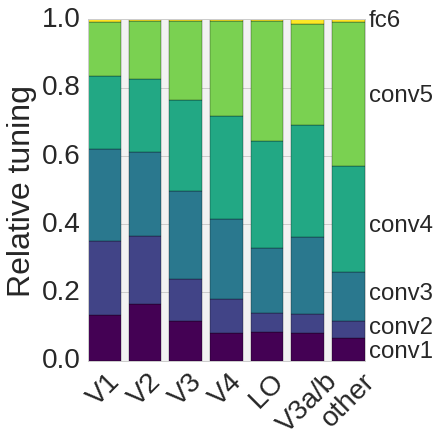

In [38]:
from matplotlib.pyplot import cm 
color=iter(cm.viridis(np.linspace(0,1,fmaps_count)))

fig = plt.figure(figsize=(6,6))
plt.subplots_adjust(left=.2, bottom=.16, right=.84, top=.95, wspace=0., hspace=0.)
c=next(color)
plist = []
#, yerr=partition_R_std[0,:]
_ = plt.bar(np.arange(len(roi_names)), partition_R_avg[0,:], color=c, align='center')
plist += [_,]
for l in range(1, fmaps_count):
    c=next(color)
    #yerr=partition_R_std[l,:]
    _= plt.bar(np.arange(len(roi_names)), partition_R_avg[l,:], bottom=np.sum(partition_R_avg[:l,:],axis=0), color=c,\
        align='center', tick_label=roi_names)
    plist += [_,]
#plt.legend(plist, ['layer %d' % l for l in range(1,len(plist)+1)], bbox_to_anchor=(1.25, 1.))
ax = plt.gca()
ax.set_ylim([0,1])
ax.set_xticklabels(roi_names, rotation=45)
ax.set_ylabel('Relative tuning', rotation=90)
ax.text(6.5, 0.01, 'conv1', fontsize=24, horizontalalignment='left')
ax.text(6.5, 0.08, 'conv2', fontsize=24, horizontalalignment='left')
ax.text(6.5, 0.18, 'conv3', fontsize=24, horizontalalignment='left')
ax.text(6.5, 0.38, 'conv4', fontsize=24, horizontalalignment='left')
ax.text(6.5, 0.76, 'conv5', fontsize=24, horizontalalignment='left')
ax.text(6.5, 0.98, 'fc6', fontsize=24, horizontalalignment='left')

In [39]:
filename = result_dir + "cifar-10_fwrf_pcp_tuning_fct_2"
fig.patch.set_alpha(0.)
fig.savefig(filename + saveext, **savearg)
plt.close()

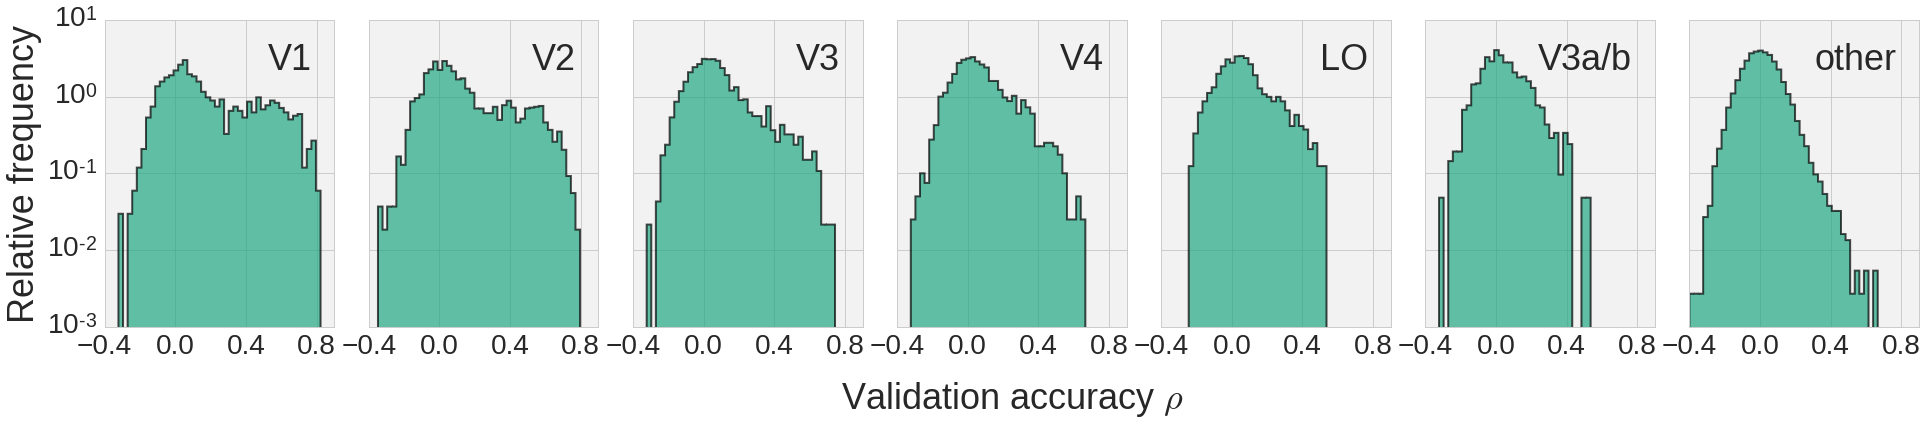

In [35]:
fig = plt.figure(figsize=(4*len(roi_names),6))
plt.subplots_adjust(left=.05, bottom=.24, right=.95, top=.95, wspace=0.15, hspace=0.)
#
for roi, value  in enumerate(iterate_roi(roi_group, voxel_roi.flatten(), roi_names)):         
    roi_mask, name = value
    ax = plt.subplot(1, len(roi_names), roi+1)
    ax.hist(val_cc[roi_mask], bins=50, range=[-0.4, 0.9], normed=True, histtype='stepfilled', alpha=0.7, color='#22a884', lw=2)
    ax.set_yscale('log') 
    ax.set_title(name, position=(0.9, 0.82), ha='right')  
    ax.set_xlim([-0.4, 0.9])
    ax.set_ylim([1e-3, 1e1])
    if roi>0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('Relative frequency', fontsize=mpl.rcParams['axes.titlesize'])
    ax.set_xticks([-0.4, 0., 0.4, 0.8])
fig.text(0.5, 0.05, r'Validation accuracy $\rho$', ha='center', fontsize=mpl.rcParams['axes.titlesize'])

In [36]:
filename = result_dir + "cifar-10_fwrf_validation_per_roi_2"
fig.patch.set_alpha(0.)
fig.savefig(filename + saveext, **savearg)
plt.close()

In [37]:
eccentricity = np.sqrt(np.square(m_data_dict['results']['rf_params'][:,0]) + np.square(m_data_dict['results']['rf_params'][:,1]))
polar_angle  = np.arctan2(m_data_dict['results']['rf_params'][:,1], m_data_dict['results']['rf_params'][:,0])
fpf_sizes    = m_data_dict['results']['rf_params'][:,2]

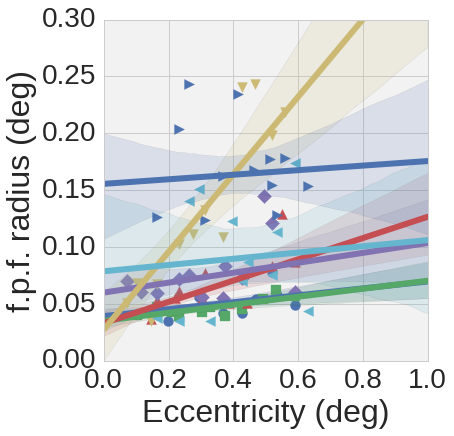

In [40]:
from scipy.optimize import curve_fit
def pooling_area(x, a, b):
    return a*x**1+b

fig = plt.figure(figsize=(6,6))
plt.subplots_adjust(left=.2, bottom=.16, right=0.95, top=.95, wspace=0., hspace=0.)
reg = np.arange(0., 11., .5)
plt.xlim(0, 1.)
plt.ylim(0., .3)

for roi, value  in enumerate(iterate_roi(roi_group, voxel_roi.flatten(), roi_names)):
    roi_mask, name = value
    mask = np.logical_and(roi_mask, val_cc>0.25)
    #mask = np.logical_and(mask, eccentricity<10.)
    ecc, size = eccentricity[mask], fpf_sizes[mask]
    ax = sns.regplot(x=ecc, y=size, color=roi_colors[name], x_bins=12, ci=False, \
                fit_reg=False, marker=roi_markers[name], scatter_kws={'alpha':1.0, 's': 100})
    sns.regplot(x=ecc, y=size, color=roi_colors[name], x_ci='sd', \
                scatter=False, label=name, line_kws={'lw':6}, scatter_kws={'alpha':0, 's': 0})
plt.xlabel('Eccentricity (deg)')
plt.ylabel('f.p.f. radius (deg)')

In [41]:
filename = result_dir + "cifar-10_fwrf_size_ecc_rel_2"
fig.patch.set_alpha(0.)
fig.savefig(filename + saveext, **savearg)
plt.close()

---

---

# Divide the validation set into test and gen sets.
- Voxels are subselected on the basis of the test set accuracy.
- Noise model is also inferred on the basis of the test set. 

In [42]:
fold0_test_idx = [3,4,9,16,17,28,29,40,48,57,61,66,70,80,84,87,89,100,116,118]
fold1_test_idx = [59, 76, 54, 106, 85, 49, 39, 93, 103, 47, 81, 95, 58, 91, 75, 14, 102, 0, 30, 45]
fold2_test_idx = [114, 13, 27, 12, 22, 63, 38, 46, 64, 67, 74, 18, 34, 25, 111, 11, 10, 32, 117, 92]
fold3_test_idx = [107, 21, 56, 115, 53, 88, 73, 109, 98, 51, 65, 86, 35, 97, 108, 101, 19, 6, 112, 96]
fold4_test_idx = [26, 31, 83, 52, 82, 1, 60, 5, 41, 24, 72, 69, 36, 20, 90, 113, 62, 2, 110, 105]
fold5_test_idx = [33, 68, 99, 15, 77, 50, 55, 23, 7, 104, 79, 78, 42, 119, 37, 8, 94, 43, 44, 71]

---

# Calculate the voxel prediction accuracy from the test set of stimulus only
- Previous scores used the whole vim-1 dataset only in order to characterize the encoding model (tuning and validation).
- This prediction accuracy is used to select the voxel that we are going to use.

In [43]:
test_mask = np.ones(shape=(len(val_voxel_data)), dtype=bool)
test_mask[fold0_test_idx] = False

In [55]:
voxelmodels = m_data_dict['results']['rf_params']
voxelparams = m_data_dict['results']['w_params']
voxelavg    = m_data_dict['results']['normavg']
voxelstd    = m_data_dict['results']['normstd']

_fmaps      = [L.get_output(a, deterministic=True) for a in aux]
fmaps_sizes = [f.shape for f in inf_fmaps]

_Vbar, _VsynthSharedVar = fwrf.get_symbolic_prediction(_fmaps, fmaps_sizes, voxelmodels, voxelparams, voxelavg, voxelstd,\
                                                       view_angle=1.0, _nonlinearity=_log_act_func)
Vbar_fn = theano.function([_X], _Vbar)

CREATING SYMBOLS

> feature map candidates 0 with shape (22701, 1, 16, 16)
> feature map candidates 1 with shape (22701, 1, 8, 8)
> feature map candidates 2 with shape (22701, 1, 6, 6)
> feature map candidates 3 with shape (22701, 1, 4, 4)
> feature map candidates 4 with shape (22701, 1, 4, 4)
> feature map candidates 5 with shape (22701, 1, 1, 1)
  total number of feature maps = 2314, in 6 layers
  feature map candidate using approx 33.7 Mb of memory (VRAM and RAM)


In [56]:
val_stim_data = stim_data[stim_trn_size:]
val_voxel_data = voxel_data[stim_trn_size:]

val_voxel_pred = np.zeros(shape=val_voxel_data.shape, dtype=fpX)
for s, (rs, ls) in tqdm(enumerate(fwrf.iterate_range(0, len(val_voxel_data), 1))):
    val_voxel_pred[rs] = Vbar_fn(val_stim_data[rs])

120it [00:04, 25.34it/s]


In [57]:
test_stim_data, gen_stim_data = val_stim_data[test_mask], val_stim_data[~test_mask]
test_voxel_data, gen_voxel_data = val_voxel_data[test_mask], val_voxel_data[~test_mask]
test_voxel_pred, gen_voxel_pred = val_voxel_pred[test_mask], val_voxel_pred[~test_mask]

In [58]:
test_voxel_cc = np.zeros(shape=(nv,), dtype=fpX)    
for v in tqdm(range(nv)):    
    test_voxel_cc[v] = np.corrcoef(test_voxel_pred[:,v], test_voxel_data[:,v])[0,1]

100%|██████████| 22701/22701 [00:01<00:00, 17118.90it/s]


V1: #497
V2: #654
V3: #364
V4: #292
LO: #154
V3a/b: #105
other: #660


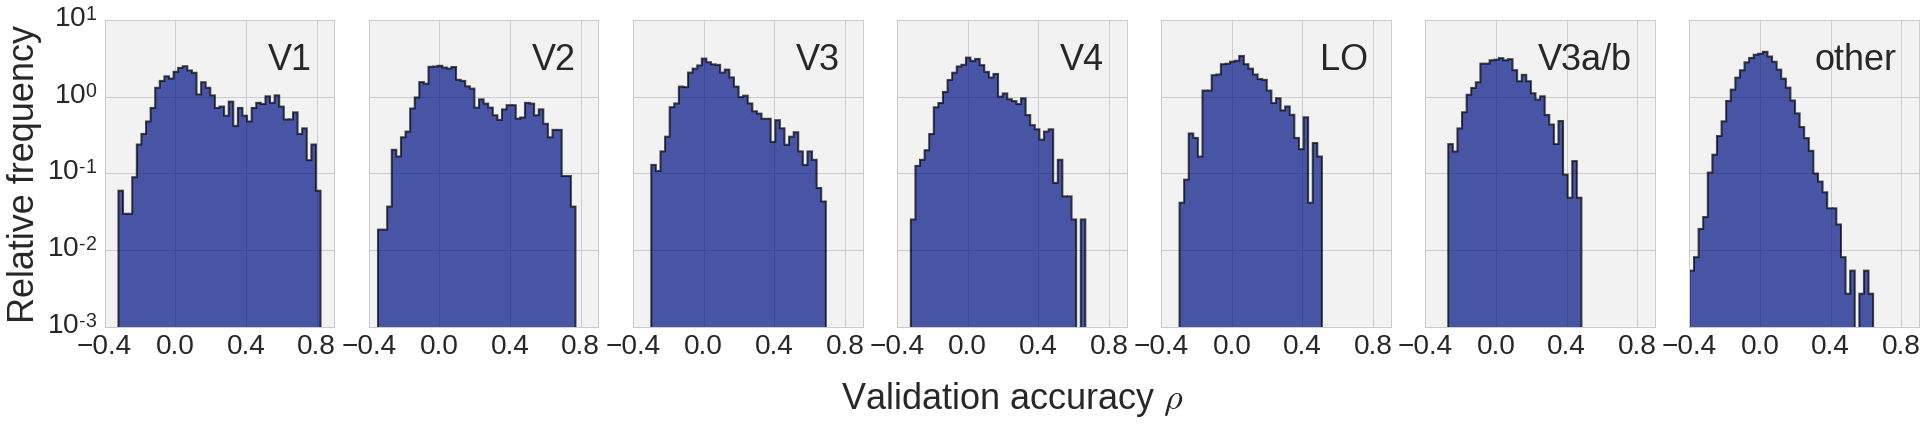

In [59]:
fig = plt.figure(figsize=(4*len(roi_names),6))
plt.subplots_adjust(left=.05, bottom=.24, right=.95, top=.95, wspace=0.15, hspace=0.)
#
for roi, value  in enumerate(iterate_roi(roi_group, voxel_roi.flatten(), roi_names)):         
    roi_mask, name = value
    ax = plt.subplot(1, len(roi_names), roi+1)
    print "%s: #%d" % (name, np.sum(test_voxel_cc[roi_mask]>0.2))
    ax.hist(test_voxel_cc[roi_mask], bins=50, range=[-0.4, 0.9], normed=True, histtype='stepfilled', alpha=0.7, color='#001184', lw=2)
    ax.set_yscale('log') 
    ax.set_title(name, position=(0.9, 0.82), ha='right')  
    ax.set_xlim([-0.4, 0.9])
    ax.set_ylim([1e-3, 1e1])
    if roi>0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('Relative frequency', fontsize=mpl.rcParams['axes.titlesize'])
    ax.set_xticks([-0.4, 0., 0.4, 0.8])
fig.text(0.5, 0.05, r'Validation accuracy $\rho$', ha='center', fontsize=mpl.rcParams['axes.titlesize'])

---
# Reduction of voxel space to include voxel with test accuracy above threshold

In [60]:
cc_mask = test_voxel_cc>0.2
print "nv = %d" % np.sum(cc_mask)
test_voxel_sub_cc = test_voxel_cc[cc_mask]
sub_nv = len(test_voxel_sub_cc)

nv = 2726


## Reduction of the voxel data

In [61]:
trn_voxel_sub_data = trn_voxel_data[:,cc_mask]
val_voxel_sub_data = val_voxel_data[:,cc_mask]
test_voxel_sub_data = test_voxel_data[:,cc_mask]
gen_voxel_sub_data = gen_voxel_data[:,cc_mask]

## Reduction of the model

In [62]:
voxelmap_sub    = np.arange(len(cc_mask))[cc_mask]
val_voxel_sub_pred_saved = m_data_dict['results']['val_pred'][:,cc_mask]
val_sub_cc      = m_data_dict['results']['val_cc'][cc_mask]
voxelmodels_sub = m_data_dict['results']['rf_params'][cc_mask,:]
voxelparams_sub = [p[cc_mask] for p in m_data_dict['results']['w_params']]
voxelavg_sub    = m_data_dict['results']['normavg'][cc_mask]
voxelstd_sub    = m_data_dict['results']['normstd'][cc_mask]

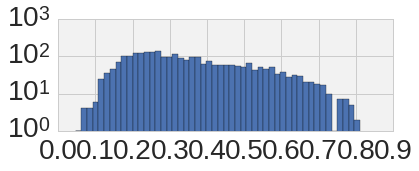

In [63]:
# the full validation accuracy just to show that the subselection gives us a good proxy to the full, 
# which is itself likely a good proxy to the real distribution.
plt.figure(figsize=(6,2))
_=plt.hist(val_sub_cc, bins=50, log=True)

# Redefine the function to predic all our 'good' voxels only.
- Perform a sanity check that the reduced model has been built correctly

In [64]:
_Vbar, _VsynthSharedVar = fwrf.get_symbolic_prediction(_fmaps, fmaps_sizes, voxelmodels_sub, voxelparams_sub, voxelavg_sub, voxelstd_sub,\
                                                       view_angle=1.0, _nonlinearity=_log_act_func)
Vbar_fn = theano.function([_X], _Vbar)

CREATING SYMBOLS

> feature map candidates 0 with shape (2726, 1, 16, 16)
> feature map candidates 1 with shape (2726, 1, 8, 8)
> feature map candidates 2 with shape (2726, 1, 6, 6)
> feature map candidates 3 with shape (2726, 1, 4, 4)
> feature map candidates 4 with shape (2726, 1, 4, 4)
> feature map candidates 5 with shape (2726, 1, 1, 1)
  total number of feature maps = 2314, in 6 layers
  feature map candidate using approx 4.0 Mb of memory (VRAM and RAM)


In [65]:
voxel_sub_pred = np.ndarray(shape=(len(stim_data), sub_nv), dtype=fpX)
batch_size = 50
for rb,rl in tqdm(fwrf.iterate_range(0, len(stim_data), batch_size)):
    voxel_sub_pred[rb,...] = Vbar_fn(stim_data[rb])
# z-score
voxel_sub_pred_avgs = np.mean(voxel_sub_pred[:stim_trn_size], axis=0)
voxel_sub_pred_stds = np.std(voxel_sub_pred[:stim_trn_size], axis=0)
voxel_sub_pred = (voxel_sub_pred - voxel_sub_pred_avgs) / voxel_sub_pred_stds

trn_voxel_sub_pred = voxel_sub_pred[:stim_trn_size] 
val_voxel_sub_pred = voxel_sub_pred[stim_trn_size:]
test_voxel_sub_pred, gen_voxel_sub_pred = val_voxel_sub_pred[test_mask], val_voxel_sub_pred[~test_mask]

38it [00:07,  4.80it/s]


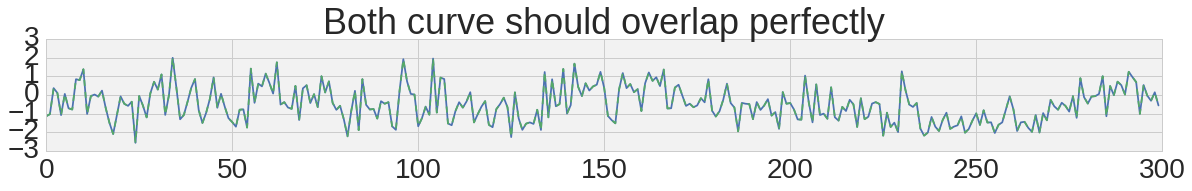

In [66]:
# sanity check
plt.figure(figsize=(20,2))
plt.plot(((val_voxel_sub_pred_saved - voxel_sub_pred_avgs) / voxel_sub_pred_stds)[0,:300])
plt.plot(val_voxel_sub_pred[0,:300], '--')
plt.title('Both curve should overlap perfectly')
# if they don't check the nonlinearity in the model space tensor vs. the symbolic nonlinearity
# easy to make a mistake

# 3) Infer the noise model parameters from the real voxel data

## A problem with the vim-1 dataset.
- The training and validation set have different 'noise' due to the validation set having more samples.
- On the other hand, the prediction from the model is uniform. Therefore, when we plug the real data into the model, it has to be somewhat scaled up to not register as low-contrast.
- We are going to z-score the output of the encoding model (and scale the validation set to match the training set (which is already z-scored)

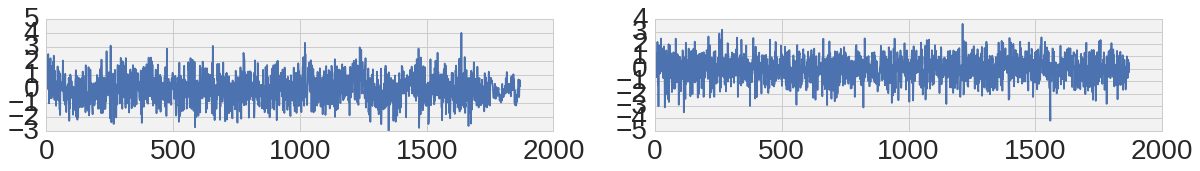

In [67]:
plt.figure(figsize=(20,2))
plt.subplot(1,2,1)
plt.plot(np.concatenate([trn_voxel_sub_data[:,1], val_voxel_sub_data[:,1]], axis=0))
plt.subplot(1,2,2)
plt.plot(np.concatenate([trn_voxel_sub_pred[:,1], val_voxel_sub_pred[:,1]], axis=0))

In [68]:
def z_score(x, axis=0):
    a = np.mean(x, axis=axis, keepdims=True)
    s = np.std(x, axis=axis, keepdims=True)
    return (x - a)/s

## Calculate the factorization of the correlation matrix of the residual between data and model prediction.

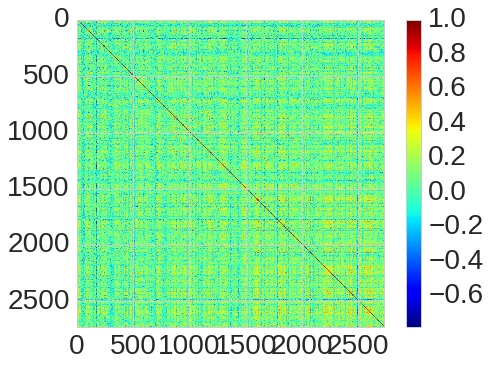

In [108]:
from numpy.linalg import cholesky
scale = np.std(test_voxel_sub_data, axis=0)
#test_noise_sub_data_diff_pred = (test_voxel_sub_data - test_voxel_sub_pred)  
#test_noise_sub_data_diff_pred = (trn_voxel_sub_data - test_voxel_sub_cc[np.newaxis,:] * trn_voxel_sub_pred)\
#                                / np.sqrt(1-np.square(test_voxel_sub_cc[np.newaxis,:]))
test_noise_sub_data_diff_pred = (test_voxel_sub_data / scale - test_voxel_sub_cc[np.newaxis,:] * test_voxel_sub_pred)\
                                / np.sqrt(fpX(1)-np.square(test_voxel_sub_cc[np.newaxis,:]))
test_noise_sub_data_diff_pred_cov = np.corrcoef(test_noise_sub_data_diff_pred.T)
test_noise_corr_matrix = cholesky(test_noise_sub_data_diff_pred_cov + np.identity(len(test_noise_sub_data_diff_pred_cov)) * 1e-12)

In [130]:
def _entropy(_p):
    return -_p * T.log2(_p)

def cc_gain(cc, g):
    a = (1-cc)/cc
    return fpX(1)/(fpX(1)+a*np.exp(-g))

from theano.tensor.shared_randomstreams import RandomStreams
def symbolic_per_voxel_correlated_noise_model(_voxels, target_cc, noiseCorrMatrix=None):
    rng = RandomStreams(seed=int(time.time()))
    _noise = rng.normal(size=_voxels.shape)
    if noiseCorrMatrix is not None:
        _noiseCorrMatrix = theano.shared(noiseCorrMatrix.astype(fpX))
        _noise = T.tensordot(_noise, _noiseCorrMatrix, [[1], [1]])
    _cc = T.patternbroadcast(theano.shared(target_cc.astype(fpX)[np.newaxis,:]), (True, False))
    #_cc = theano.shared(target_cc.astype(fpX).reshape((1,-1)))
    _delta, _epsilon = _cc, T.sqrt((fpX(1) - T.sqr(_cc)))
    return _voxels * _delta + _noise * _epsilon, _cc
    
_V = T.matrix()
#_Vsynth, _voxel_cc = symbolic_per_voxel_correlated_noise_model(_V, cc_gain(test_voxel_sub_cc,0.))
_Vsynth, _voxel_cc = symbolic_per_voxel_correlated_noise_model(_V, cc_gain(test_voxel_sub_cc,0.), test_noise_corr_matrix)
#_Vsynth = _V ########## bypass
Vsynth_fn = theano.function([_V], _Vsynth)

## An example of the accuracy between the noise modeled activity and the activity expectation value (i.e. encoding model prediction). 

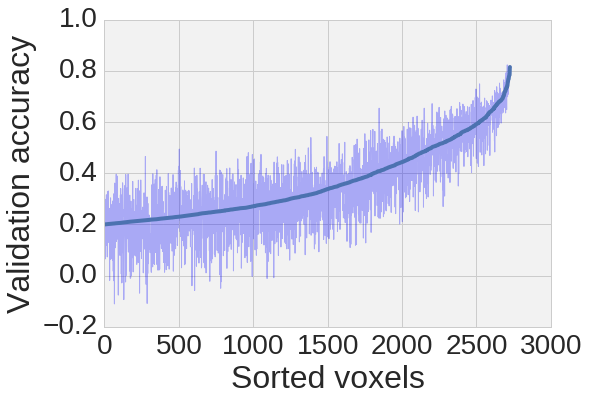

In [133]:
test_voxel_synth_data = Vsynth_fn(test_voxel_sub_pred)
voxel_sub_order = np.argsort(test_voxel_sub_cc)
test_voxel_synth_cc = np.zeros(shape=(sub_nv,))
for v in range(sub_nv):
    test_voxel_synth_cc[v] = np.corrcoef(test_voxel_synth_data[:,v], test_voxel_sub_pred[:,v])[0,1]
    
plt.plot(test_voxel_synth_cc[voxel_sub_order], color='b', alpha=0.3, lw=1)
plt.plot(test_voxel_sub_cc[voxel_sub_order], color=sns.color_palette("deep")[0], lw=4)

plt.xlabel('Sorted voxels')
plt.ylabel('Validation accuracy')

# Prepare the synthetic training set (no more real brain data)

In [72]:
from src.load_images import load_cifar10
cifar_root = "/home/styvesg/Documents/PostDoc/Datasets/cifar-10/"
input_data, label_data, label_map, input_trn_size = load_cifar10(cifar_root)

input_data_size = len(input_data)
input_val_size = input_data_size - input_trn_size

input_data -= 0.5
trn_input_data = input_data[:input_trn_size]
val_input_data = input_data[input_trn_size:] 

trn_label_data = label_data[:input_trn_size]
val_label_data = label_data[input_trn_size:]

loading data_batch_1...
loading data_batch_2...
loading data_batch_3...
loading data_batch_4...
loading data_batch_5...
loading test_batch...


## 1) Calculate the expectation value from the encoding model

In [87]:
voxel_synth_pred = np.ndarray(shape=(input_data_size, sub_nv), dtype=fpX)
batch_size = 50

b = 0
for xb,_ in tqdm(fwrf.iterate_minibatches(input_data, label_data, batch_size)):
    voxel_synth_pred[b*batch_size:(b+1)*batch_size,:] = Vbar_fn(xb)
    b += 1
# z-score
voxel_synth_pred_avgs = np.mean(voxel_synth_pred[:input_trn_size], axis=0)
voxel_synth_pred_stds = np.std(voxel_synth_pred[:input_trn_size], axis=0)
voxel_synth_pred = (voxel_synth_pred - voxel_synth_pred_avgs) / voxel_synth_pred_stds

trn_voxel_synth_pred = voxel_synth_pred[:input_trn_size] 
val_voxel_synth_pred = voxel_synth_pred[input_trn_size:]

1200it [04:15,  4.67it/s]


## 2) Add noise to obtain a sample from the synthetic data distribution
- Samples are going to be obtained 'on the fly' during training

In [134]:
voxel_synth_data = np.zeros(shape=voxel_synth_pred.shape, dtype=fpX)
batch_size = 500
b = 0
for vb, vpb in tqdm(fwrf.iterate_minibatches(voxel_synth_pred, voxel_synth_pred, batch_size)):
    voxel_synth_data[b*batch_size:(b+1)*batch_size] = Vsynth_fn(vb)
    b += 1
trn_voxel_synth_data = voxel_synth_data[:input_trn_size] 
val_voxel_synth_data = voxel_synth_data[input_trn_size:]

120it [00:07, 15.84it/s]


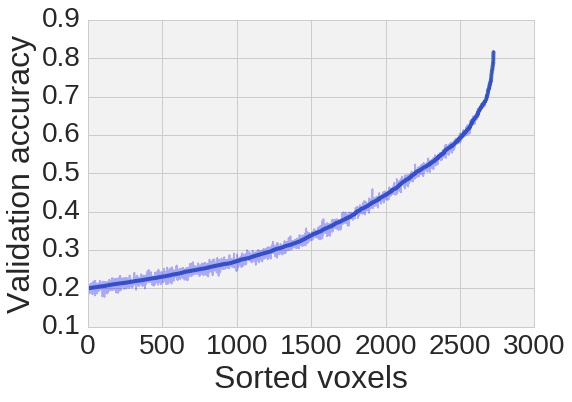

In [136]:
val_voxel_synth_cc = np.zeros(shape=(sub_nv,))
for v in range(sub_nv):
    val_voxel_synth_cc[v] = np.corrcoef(val_voxel_synth_data[:,v], val_voxel_synth_pred[:,v])[0,1]

plt.plot(test_voxel_sub_cc[voxel_sub_order], color=sns.color_palette("deep")[0], lw=4)
plt.plot(val_voxel_synth_cc[voxel_sub_order], color='b', alpha=0.3)

plt.xlabel('Sorted voxels')
plt.ylabel('Validation accuracy')

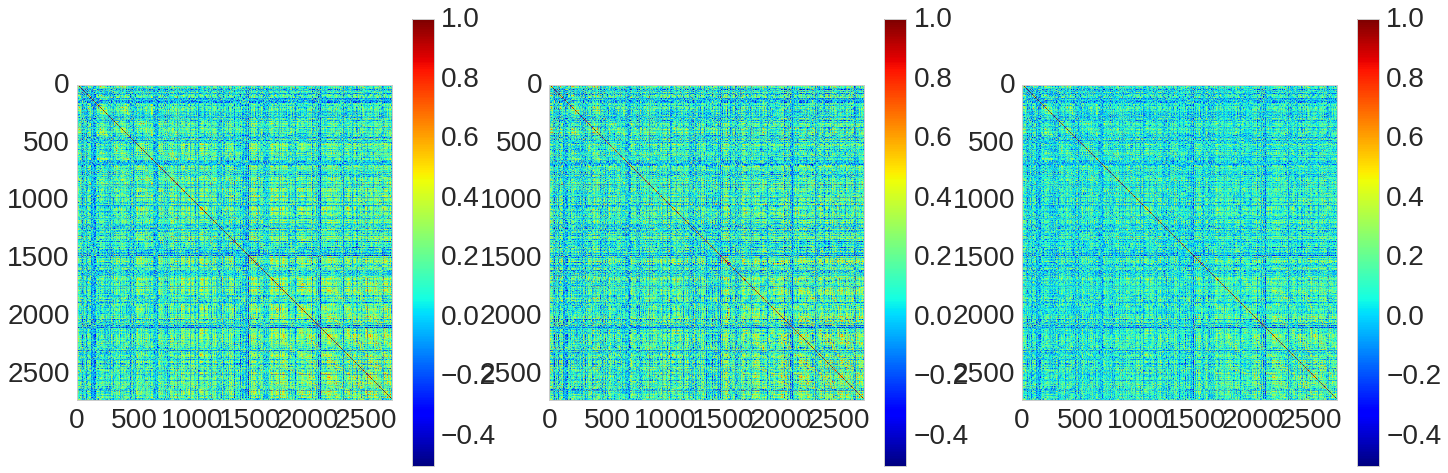

In [137]:
plt.figure(figsize=(24,8))
plt.subplot(1,3,1)
plt.imshow(np.cov((test_voxel_sub_data / scale).T), cmap='jet')
plt.clim([-0.5, 1])
plt.colorbar()
plt.grid('off')
plt.subplot(1,3,2)
plt.imshow(np.cov(Vsynth_fn(test_voxel_sub_pred).T), cmap='jet')
plt.clim([-0.5, 1])
plt.colorbar()
plt.grid('off')
plt.subplot(1,3,3)
plt.imshow(np.cov(val_voxel_synth_data.T), cmap='jet')
plt.clim([-0.5, 1])
plt.colorbar()
plt.grid('off')

# Train the denoising autoencoder

In [156]:
from net.cifar10_definitions import enc_net, dec_net

_Vbar = T.matrix() # the denoised target -- the modelable part of the measured voxel activity

_enc_input = L.InputLayer(shape=(None, sub_nv), input_var=_V, name='V')
_enc = enc_net(_enc_input, output_channels=128, drop_rate=0., nonlinearity=NL.sigmoid) # NL.sigmoid
_dec = dec_net(_enc, output_channels=sub_nv, nonlinearity=None)

plu.print_lasagne_network(_dec, skipnoparam=True)

Layer	: <lasagne.layers.input.InputLayer object at 0x7fd34f38dc90>
Name	: V
Type	: <class 'lasagne.layers.input.InputLayer'>
Shape	: (None, 2726)


Layer	: <lasagne.layers.dense.DenseLayer object at 0x7fd34f38d6d0>
Name	: None
Type	: <class 'lasagne.layers.dense.DenseLayer'>
Shape	: (None, 512)
Params
        |-- W         : (2726, 512)
        |-- b         : (512,)


Layer	: <lasagne.layers.dense.DenseLayer object at 0x7fd34f1e5ed0>
Name	: None
Type	: <class 'lasagne.layers.dense.DenseLayer'>
Shape	: (None, 128)
Params
        |-- W         : (512, 128)
        |-- b         : (128,)


Layer	: <lasagne.layers.dense.DenseLayer object at 0x7fd34f1e5450>
Name	: None
Type	: <class 'lasagne.layers.dense.DenseLayer'>
Shape	: (None, 512)
Params
        |-- W         : (128, 512)


Layer	: <lasagne.layers.dense.DenseLayer object at 0x7fcbe4f7d7d0>
Name	: None
Type	: <class 'lasagne.layers.dense.DenseLayer'>
Shape	: (None, 2726)
Params
        |-- W         : (512, 2726)
        |-- b        

## Autoencoder with fake noisy data

In [157]:
# _Vbar is the model prediction (without noise)
# _Vsynth is the model prediction with noise model infered from voxel data validation set.

_lr = theano.shared(fpX(0))
_l2 = theano.shared(fpX(0))

_enc_trn = L.get_output(_enc, inputs=_Vsynth, deterministic=False)
_enc_val  = L.get_output(_enc, inputs=_V, deterministic=True)
_enc_synth = L.get_output(_enc, inputs=_Vsynth, deterministic=True)
_enc_reg = _l2 * R.regularize_layer_params(_enc, R.l2)
enc_params = L.get_all_params(_enc, trainable=True)

_dec_trn = L.get_output(_dec, inputs=_Vsynth, deterministic=False)
_dec_val  = L.get_output(_dec, inputs=_V, deterministic=True)
_dec_synth = L.get_output(_dec, inputs=_Vsynth, deterministic=True)
_dec_reg = _l2 * R.regularize_layer_params(_dec, R.l2)
dec_params = L.get_all_params(_dec, trainable=True)
print dec_params

auto_loss = (O.squared_error(_dec_trn, _Vbar) * _voxel_cc).mean() #+ 0.01 * plu.pullaway_loss(T.flatten(_enc_trn, outdim=2)) # + _enc_reg
# + 0.001 * _entropy(_enc_trn).mean() #* O.squared_error(_enc_trn, _enc_alt).mean()
#auto_updates = lasagne.updates.sgd(auto_loss, dec_params, learning_rate=_lr)
auto_updates = lasagne.updates.adam(auto_loss, dec_params, learning_rate=_lr, beta1=0.5, epsilon=1e-6)

_cc_synth = ((_dec_synth - _dec_synth.mean(axis=0, keepdims=True)) * (_Vbar - _Vbar.mean(axis=0, keepdims=True))).mean(axis=0) / \
    T.sqrt(T.sqr(_dec_synth - _dec_synth.mean(axis=0, keepdims=True)).mean(axis=0) * T.sqr(_Vbar - _Vbar.mean(axis=0, keepdims=True)).mean(axis=0))
_cc_val = ((_dec_val - _dec_val.mean(axis=0, keepdims=True)) * (_Vbar - _Vbar.mean(axis=0, keepdims=True))).mean(axis=0) / \
    T.sqrt(T.sqr(_dec_val - _dec_val.mean(axis=0, keepdims=True)).mean(axis=0) * T.sqr(_Vbar - _Vbar.mean(axis=0, keepdims=True)).mean(axis=0))
print '\nCOMPILING'
t = time.time()
# updates=OrderedDict(dict(dec_updates, **auto_updates)))
train_auto = theano.function([_V, _Vbar], auto_loss, updates=auto_updates)
enc_val  = theano.function([_V], _enc_val)
dec_val = theano.function([_V], _dec_val)
enc_synth = theano.function([_V], _enc_synth) # here _V is the prediction
dec_synth = theano.function([_V], _dec_synth)
cc_synth  = theano.function([_V, _Vbar], _cc_synth)
cc_val  = theano.function([_V, _Vbar], _cc_val)
print '%.2f seconds to compile theano functions'%(time.time()-t)

[W, b, W, b, W, W, b]

COMPILING
1.60 seconds to compile theano functions


In [158]:
niter = 50       # # of iter at starting learning rate
perc_decay = 2.  # # percentage decay every niter iterations
num_epochs = 100
batch_size = 200

_lr.set_value(fpX(1e-3)) # initial learning rate 1e-3 for adam
_l2.set_value(fpX(1e-3)) # l2 weight decay

trn_hist = []
auto_cc_hist = []

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_batches = 0
    auto_loss = 0
    start_time = time.time()
     
    for vb, vpb in tqdm(fwrf.iterate_minibatches(trn_voxel_synth_pred, trn_voxel_synth_pred, batch_size)):   
        auto_loss += train_auto(vb, vpb)

    synth_auto_cc = np.mean(cc_synth(test_voxel_sub_pred, test_voxel_sub_pred))
    test_auto_cc = np.mean(cc_val(test_voxel_sub_data / scale, test_voxel_sub_pred))
    
    trn_hist += [auto_loss,]
    auto_cc_hist += [(synth_auto_cc, test_auto_cc),]
    print("\nEpoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("Costs: %.3f") % (auto_loss) 
    print("<CC>: synth=%.3f, test=%.3f") % (synth_auto_cc, test_auto_cc)    
    if epoch > niter:
        _lr.set_value(fpX(_lr.get_value() * (1.0 - perc_decay / 100.0)))     
    sys.stdout.flush()

250it [00:06, 36.50it/s]


Epoch 1 of 100 took 6.973s
Costs: 58.162
<CC>: synth=0.629, test=0.615



250it [00:06, 36.57it/s]


Epoch 2 of 100 took 6.852s
Costs: 37.715
<CC>: synth=0.660, test=0.647



250it [00:06, 36.66it/s]


Epoch 3 of 100 took 6.836s
Costs: 30.953
<CC>: synth=0.690, test=0.670



250it [00:06, 36.47it/s]


Epoch 4 of 100 took 6.870s
Costs: 27.356
<CC>: synth=0.710, test=0.692



250it [00:06, 36.55it/s]


Epoch 5 of 100 took 6.856s
Costs: 25.502
<CC>: synth=0.716, test=0.694



250it [00:06, 36.74it/s]


Epoch 6 of 100 took 6.820s
Costs: 23.962
<CC>: synth=0.721, test=0.697



250it [00:06, 36.58it/s]


Epoch 7 of 100 took 6.850s
Costs: 22.801
<CC>: synth=0.737, test=0.718



250it [00:06, 35.90it/s]


Epoch 8 of 100 took 6.980s
Costs: 21.961
<CC>: synth=0.741, test=0.720



250it [00:06, 36.01it/s]


Epoch 9 of 100 took 6.959s
Costs: 21.163
<CC>: synth=0.749, test=0.728



250it [00:06, 36.39it/s]


Epoch 10 of 100 took 6.887s
Costs: 20.428
<CC>: synth=0.756, test=0.733



250it [00:06, 36.23it/s]


Epoch 11 of 100 took 6.917s
Costs: 19.888
<CC>: synth=0.763, test=0.741



250it [00:06, 36.74it/s]


Epoch 12 of 100 took 6.820s
Costs: 19.292
<CC>: synth=0.766, test=0.742



250it [00:06, 36.77it/s]


Epoch 13 of 100 took 6.816s
Costs: 18.812
<CC>: synth=0.768, test=0.746



250it [00:06, 36.60it/s]


Epoch 14 of 100 took 6.847s
Costs: 18.422
<CC>: synth=0.775, test=0.752



250it [00:06, 36.74it/s]


Epoch 15 of 100 took 6.821s
Costs: 18.049
<CC>: synth=0.777, test=0.753



250it [00:06, 36.04it/s]


Epoch 16 of 100 took 6.952s
Costs: 17.667
<CC>: synth=0.783, test=0.755



250it [00:06, 36.62it/s]


Epoch 17 of 100 took 6.843s
Costs: 17.362
<CC>: synth=0.785, test=0.760



250it [00:06, 36.75it/s]


Epoch 18 of 100 took 6.819s
Costs: 17.039
<CC>: synth=0.790, test=0.760



250it [00:06, 36.65it/s]


Epoch 19 of 100 took 6.837s
Costs: 16.754
<CC>: synth=0.791, test=0.761



250it [00:06, 36.69it/s]


Epoch 20 of 100 took 6.829s
Costs: 16.517
<CC>: synth=0.790, test=0.760



250it [00:06, 36.59it/s]


Epoch 21 of 100 took 6.851s
Costs: 16.223
<CC>: synth=0.797, test=0.766



250it [00:06, 36.64it/s]


Epoch 22 of 100 took 6.839s
Costs: 16.108
<CC>: synth=0.797, test=0.768



250it [00:06, 36.51it/s]


Epoch 23 of 100 took 6.865s
Costs: 15.867
<CC>: synth=0.799, test=0.769



250it [00:06, 36.43it/s]


Epoch 24 of 100 took 6.878s
Costs: 15.646
<CC>: synth=0.801, test=0.771



250it [00:06, 36.40it/s]


Epoch 25 of 100 took 6.884s
Costs: 15.457
<CC>: synth=0.800, test=0.771



250it [00:06, 36.62it/s]


Epoch 26 of 100 took 6.844s
Costs: 15.270
<CC>: synth=0.803, test=0.771



250it [00:06, 35.99it/s]


Epoch 27 of 100 took 6.963s
Costs: 15.084
<CC>: synth=0.803, test=0.772



250it [00:06, 35.99it/s]


Epoch 28 of 100 took 6.964s
Costs: 14.957
<CC>: synth=0.805, test=0.774



250it [00:06, 36.65it/s]


Epoch 29 of 100 took 6.838s
Costs: 14.722
<CC>: synth=0.807, test=0.776



250it [00:06, 35.78it/s]


Epoch 30 of 100 took 7.004s
Costs: 14.603
<CC>: synth=0.808, test=0.776



250it [00:06, 36.62it/s]


Epoch 31 of 100 took 6.844s
Costs: 14.451
<CC>: synth=0.810, test=0.777



250it [00:06, 35.91it/s]


Epoch 32 of 100 took 6.978s
Costs: 14.329
<CC>: synth=0.811, test=0.776



250it [00:06, 36.06it/s]


Epoch 33 of 100 took 6.948s
Costs: 14.148
<CC>: synth=0.814, test=0.780



250it [00:06, 36.12it/s]


Epoch 34 of 100 took 6.937s
Costs: 14.047
<CC>: synth=0.813, test=0.777



250it [00:06, 36.70it/s]


Epoch 35 of 100 took 6.828s
Costs: 13.928
<CC>: synth=0.816, test=0.780



250it [00:06, 36.49it/s]


Epoch 36 of 100 took 6.867s
Costs: 13.766
<CC>: synth=0.815, test=0.780



250it [00:06, 36.58it/s]


Epoch 37 of 100 took 6.850s
Costs: 13.647
<CC>: synth=0.817, test=0.783



250it [00:06, 36.74it/s]


Epoch 38 of 100 took 6.821s
Costs: 13.506
<CC>: synth=0.820, test=0.785



250it [00:06, 36.59it/s]


Epoch 39 of 100 took 6.848s
Costs: 13.408
<CC>: synth=0.822, test=0.784



250it [00:06, 36.69it/s]


Epoch 40 of 100 took 6.831s
Costs: 13.316
<CC>: synth=0.820, test=0.786



250it [00:06, 36.64it/s]


Epoch 41 of 100 took 6.839s
Costs: 13.176
<CC>: synth=0.823, test=0.787



250it [00:06, 36.63it/s]


Epoch 42 of 100 took 6.842s
Costs: 13.085
<CC>: synth=0.822, test=0.785



250it [00:07, 35.52it/s]


Epoch 43 of 100 took 7.056s
Costs: 12.980
<CC>: synth=0.822, test=0.784



250it [00:06, 36.32it/s]


Epoch 44 of 100 took 6.900s
Costs: 12.899
<CC>: synth=0.825, test=0.787



250it [00:06, 35.78it/s]


Epoch 45 of 100 took 7.006s
Costs: 12.802
<CC>: synth=0.827, test=0.790



250it [00:06, 35.84it/s]


Epoch 46 of 100 took 6.991s
Costs: 12.724
<CC>: synth=0.827, test=0.789



250it [00:06, 36.56it/s]


Epoch 47 of 100 took 6.855s
Costs: 12.616
<CC>: synth=0.827, test=0.791



250it [00:06, 36.51it/s]


Epoch 48 of 100 took 6.863s
Costs: 12.525
<CC>: synth=0.830, test=0.791



250it [00:06, 36.59it/s]


Epoch 49 of 100 took 6.849s
Costs: 12.467
<CC>: synth=0.831, test=0.793



250it [00:06, 36.46it/s]


Epoch 50 of 100 took 6.874s
Costs: 12.395
<CC>: synth=0.829, test=0.790



250it [00:06, 36.40it/s]


Epoch 51 of 100 took 6.885s
Costs: 12.303
<CC>: synth=0.831, test=0.792



250it [00:06, 36.70it/s]


Epoch 52 of 100 took 6.828s
Costs: 12.283
<CC>: synth=0.831, test=0.792



250it [00:06, 36.65it/s]


Epoch 53 of 100 took 6.837s
Costs: 12.054
<CC>: synth=0.833, test=0.794



250it [00:06, 36.62it/s]


Epoch 54 of 100 took 6.844s
Costs: 11.900
<CC>: synth=0.835, test=0.796



250it [00:06, 36.49it/s]


Epoch 55 of 100 took 6.867s
Costs: 11.826
<CC>: synth=0.835, test=0.796



250it [00:06, 36.33it/s]


Epoch 56 of 100 took 6.898s
Costs: 11.714
<CC>: synth=0.836, test=0.797



250it [00:06, 36.46it/s]


Epoch 57 of 100 took 6.874s
Costs: 11.602
<CC>: synth=0.837, test=0.797



250it [00:06, 36.33it/s]


Epoch 58 of 100 took 6.898s
Costs: 11.537
<CC>: synth=0.836, test=0.797



250it [00:06, 37.07it/s]


Epoch 59 of 100 took 6.760s
Costs: 11.451
<CC>: synth=0.837, test=0.797



250it [00:06, 37.19it/s]


Epoch 60 of 100 took 6.738s
Costs: 11.341
<CC>: synth=0.838, test=0.799



250it [00:06, 37.07it/s]


Epoch 61 of 100 took 6.761s
Costs: 11.282
<CC>: synth=0.838, test=0.797



250it [00:06, 37.09it/s]


Epoch 62 of 100 took 6.757s
Costs: 11.197
<CC>: synth=0.840, test=0.798



250it [00:06, 36.68it/s]


Epoch 63 of 100 took 6.831s
Costs: 11.114
<CC>: synth=0.841, test=0.799



250it [00:06, 36.77it/s]


Epoch 64 of 100 took 6.814s
Costs: 11.049
<CC>: synth=0.841, test=0.800



250it [00:06, 36.88it/s]


Epoch 65 of 100 took 6.795s
Costs: 10.991
<CC>: synth=0.841, test=0.800



250it [00:06, 36.26it/s]


Epoch 66 of 100 took 6.911s
Costs: 10.918
<CC>: synth=0.841, test=0.801



250it [00:06, 36.26it/s]


Epoch 67 of 100 took 6.910s
Costs: 10.848
<CC>: synth=0.842, test=0.800



250it [00:06, 36.86it/s]


Epoch 68 of 100 took 6.799s
Costs: 10.801
<CC>: synth=0.842, test=0.802



250it [00:06, 36.33it/s]


Epoch 69 of 100 took 6.897s
Costs: 10.745
<CC>: synth=0.843, test=0.802



250it [00:06, 36.97it/s]


Epoch 70 of 100 took 6.777s
Costs: 10.670
<CC>: synth=0.843, test=0.801



250it [00:06, 37.08it/s]


Epoch 71 of 100 took 6.759s
Costs: 10.632
<CC>: synth=0.843, test=0.801



250it [00:06, 37.07it/s]


Epoch 72 of 100 took 6.759s
Costs: 10.577
<CC>: synth=0.845, test=0.803



250it [00:06, 37.16it/s]


Epoch 73 of 100 took 6.743s
Costs: 10.520
<CC>: synth=0.844, test=0.803



250it [00:06, 36.52it/s]


Epoch 74 of 100 took 6.861s
Costs: 10.468
<CC>: synth=0.845, test=0.804



250it [00:06, 36.64it/s]


Epoch 75 of 100 took 6.839s
Costs: 10.428
<CC>: synth=0.845, test=0.803



250it [00:06, 36.66it/s]


Epoch 76 of 100 took 6.835s
Costs: 10.376
<CC>: synth=0.845, test=0.803



250it [00:06, 36.54it/s]


Epoch 77 of 100 took 6.858s
Costs: 10.338
<CC>: synth=0.846, test=0.804



250it [00:06, 35.72it/s]


Epoch 78 of 100 took 7.015s
Costs: 10.284
<CC>: synth=0.846, test=0.804



250it [00:06, 35.90it/s]


Epoch 79 of 100 took 6.979s
Costs: 10.251
<CC>: synth=0.846, test=0.804



250it [00:06, 36.49it/s]


Epoch 80 of 100 took 6.867s
Costs: 10.206
<CC>: synth=0.847, test=0.805



250it [00:06, 36.25it/s]


Epoch 81 of 100 took 6.914s
Costs: 10.173
<CC>: synth=0.847, test=0.805



250it [00:06, 36.67it/s]


Epoch 82 of 100 took 6.833s
Costs: 10.129
<CC>: synth=0.847, test=0.805



250it [00:06, 36.42it/s]


Epoch 83 of 100 took 6.881s
Costs: 10.100
<CC>: synth=0.847, test=0.806



250it [00:06, 35.85it/s]


Epoch 84 of 100 took 6.990s
Costs: 10.072
<CC>: synth=0.848, test=0.805



250it [00:06, 36.09it/s]


Epoch 85 of 100 took 6.943s
Costs: 10.024
<CC>: synth=0.849, test=0.806



250it [00:06, 36.04it/s]


Epoch 86 of 100 took 6.953s
Costs: 10.000
<CC>: synth=0.848, test=0.804



250it [00:06, 36.05it/s]


Epoch 87 of 100 took 6.953s
Costs: 9.956
<CC>: synth=0.848, test=0.806



250it [00:06, 36.30it/s]


Epoch 88 of 100 took 6.903s
Costs: 9.935
<CC>: synth=0.848, test=0.805



250it [00:06, 36.37it/s]


Epoch 89 of 100 took 6.895s
Costs: 9.905
<CC>: synth=0.849, test=0.806



250it [00:06, 36.28it/s]


Epoch 90 of 100 took 6.907s
Costs: 9.880
<CC>: synth=0.849, test=0.806



250it [00:06, 36.30it/s]


Epoch 91 of 100 took 6.909s
Costs: 9.849
<CC>: synth=0.849, test=0.807



250it [00:06, 36.79it/s]


Epoch 92 of 100 took 6.811s
Costs: 9.818
<CC>: synth=0.850, test=0.807



250it [00:06, 36.77it/s]


Epoch 93 of 100 took 6.816s
Costs: 9.795
<CC>: synth=0.850, test=0.806



250it [00:06, 36.75it/s]


Epoch 94 of 100 took 6.819s
Costs: 9.782
<CC>: synth=0.849, test=0.806



250it [00:06, 36.72it/s]


Epoch 95 of 100 took 6.825s
Costs: 9.740
<CC>: synth=0.849, test=0.806



250it [00:06, 36.41it/s]


Epoch 96 of 100 took 6.882s
Costs: 9.726
<CC>: synth=0.850, test=0.806



250it [00:06, 36.77it/s]


Epoch 97 of 100 took 6.816s
Costs: 9.715
<CC>: synth=0.850, test=0.806



250it [00:06, 36.62it/s]


Epoch 98 of 100 took 6.845s
Costs: 9.672
<CC>: synth=0.850, test=0.807



250it [00:06, 36.24it/s]


Epoch 99 of 100 took 6.915s
Costs: 9.666
<CC>: synth=0.850, test=0.806



250it [00:07, 35.34it/s]


Epoch 100 of 100 took 7.091s
Costs: 9.640
<CC>: synth=0.851, test=0.807


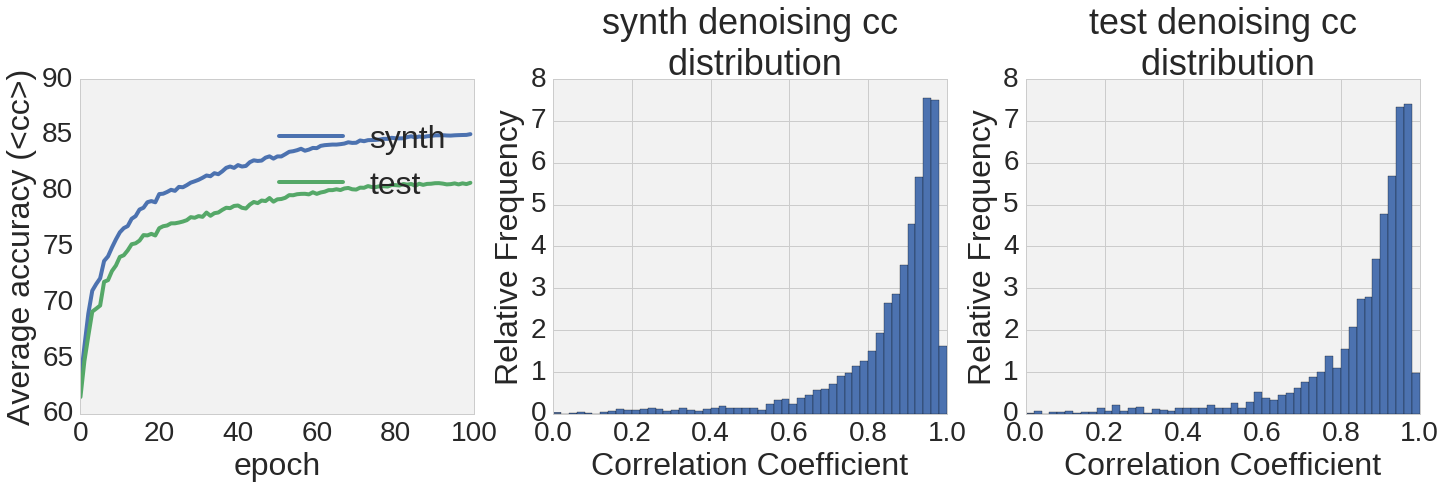

In [161]:
test_auto_synth_cc = cc_synth(test_voxel_sub_pred, test_voxel_sub_pred)
test_auto_sub_cc = cc_val(test_voxel_sub_data / scale, test_voxel_sub_pred)

plt.figure(figsize=(24,6))
plt.subplot(1,3,1)
#plt.plot(trn_hist, 'b', label='trn', lw=2)
plt.plot(np.array(auto_cc_hist)[:,0] * 100, label='synth', lw=4)
plt.plot(np.array(auto_cc_hist)[:,1] * 100, label='test', lw=4)
plt.xlabel('epoch')
plt.ylabel('Average accuracy (<cc>)')
plt.legend(bbox_to_anchor=(1., 0.95))
plt.grid()

plt.subplot(1,3,2)
plt.hist(test_auto_synth_cc , bins=50, range=(0,1), normed=True)
plt.xlabel("Correlation Coefficient")
plt.ylabel("Relative Frequency")
plt.title('synth denoising cc\n distribution')

plt.subplot(1,3,3)
plt.hist(test_auto_sub_cc, bins=50, range=(0,1), normed=True)
#plt.hist(trn_denoise_cc[1], bins=50, range=(0,1), normed=True)
plt.xlabel("Correlation Coefficient")
plt.ylabel("Relative Frequency")
plt.title('test denoising cc\n distribution')

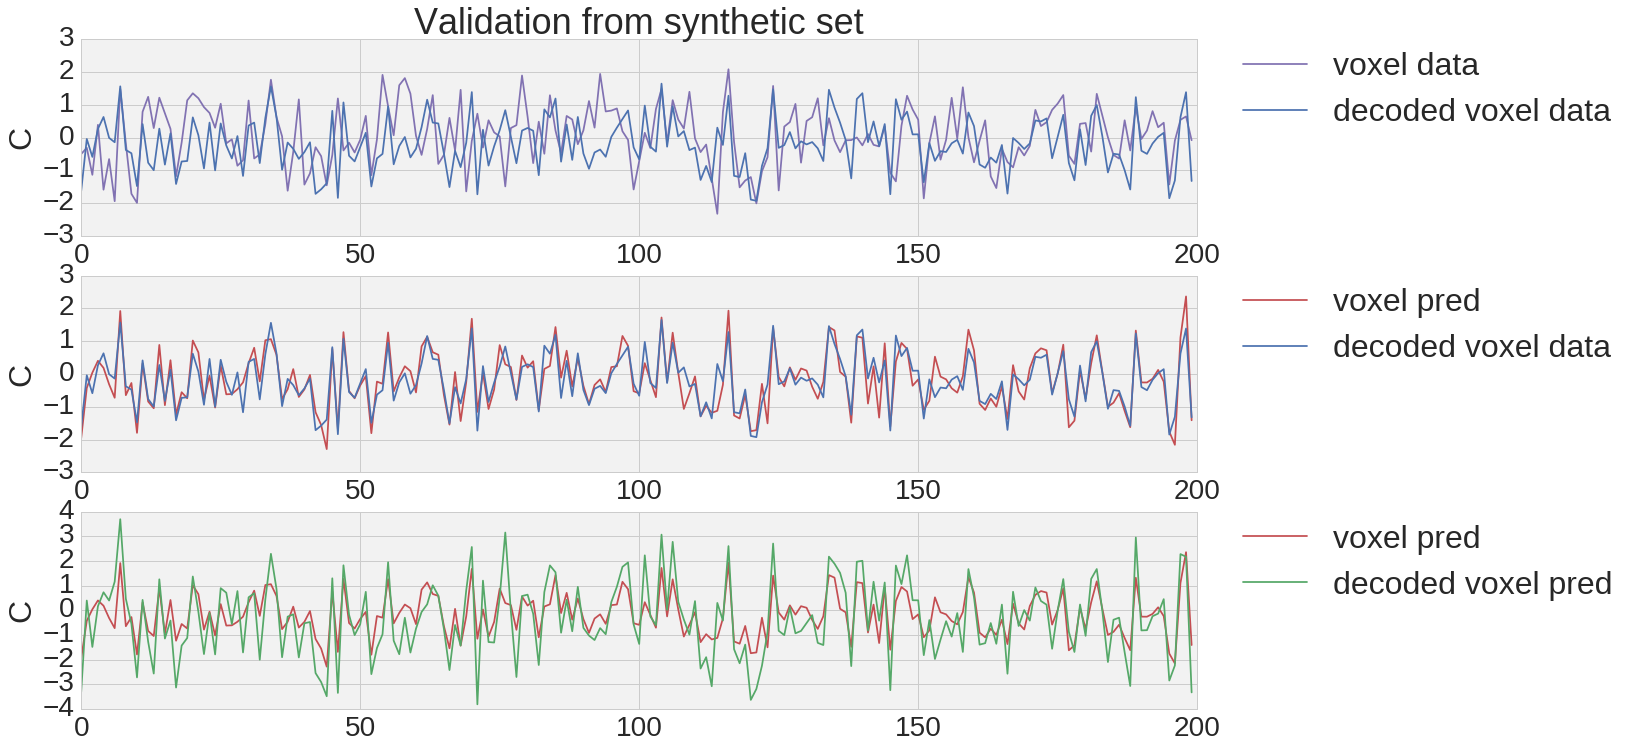

In [162]:
n = 3
trn_dec_synth_data = dec_val(val_voxel_synth_data)
trn_dec_synth_pred = dec_val(val_voxel_synth_pred)
plt.figure(figsize=(20,12))
plt.subplot(3,1,1)
for s in range(1):
    p=plt.plot(val_voxel_synth_data[n+s,:200], linestyle='-', color=sns.color_palette("deep")[3], label='voxel data')
    plt.plot(trn_dec_synth_data[n+s,:200], linestyle='-', color=sns.color_palette("deep")[0], label='decoded voxel data')
plt.ylabel('C') 
plt.title('Validation from synthetic set')
plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0.)
plt.subplot(3,1,2)
for s in range(1):
    p=plt.plot(val_voxel_synth_pred[n+s,:200], linestyle='-', color=sns.color_palette("deep")[2], label='voxel pred')
    plt.plot(trn_dec_synth_data[n+s,:200], linestyle='-', color=sns.color_palette("deep")[0], label='decoded voxel data')
plt.ylabel('C') 
plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0.)
plt.subplot(3,1,3)
for s in range(1):
    p=plt.plot(val_voxel_synth_pred[n+s,:200], linestyle='-', color=sns.color_palette("deep")[2], label='voxel pred')
    plt.plot(trn_dec_synth_pred[n+s,:200], linestyle='-', color=sns.color_palette("deep")[1], label='decoded voxel pred')
plt.ylabel('C') 
plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0.)

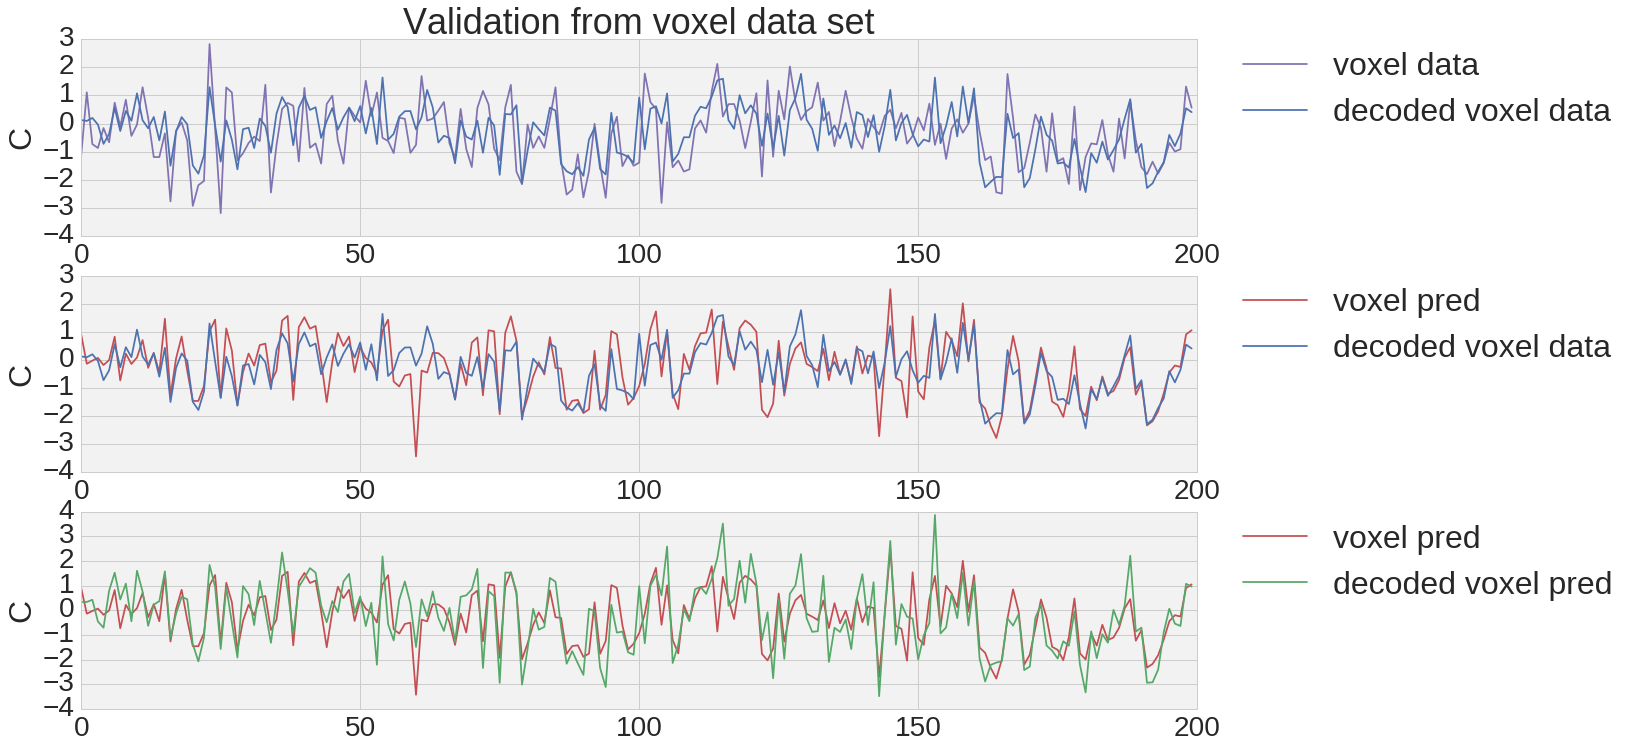

In [163]:
n = 3
test_dec_sub_data = dec_val(test_voxel_sub_data / scale)
test_dec_sub_pred = dec_val(test_voxel_sub_pred)
plt.figure(figsize=(20,12))
plt.subplot(3,1,1)
for s in range(1):
    p=plt.plot((test_voxel_sub_data  / scale)[n+s,:200], linestyle='-', color=sns.color_palette("deep")[3], label='voxel data')
    plt.plot(test_dec_sub_data[n+s,:200], linestyle='-', color=sns.color_palette("deep")[0], label='decoded voxel data')
plt.ylabel('C') 
plt.title('Validation from voxel data set')
plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0.)
plt.subplot(3,1,2)
for s in range(1):
    p=plt.plot(test_voxel_sub_pred[n+s,:200], linestyle='-', color=sns.color_palette("deep")[2], label='voxel pred')
    plt.plot(test_dec_sub_data[n+s,:200], linestyle='-', color=sns.color_palette("deep")[0], label='decoded voxel data')
plt.ylabel('C') 
plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0.)
plt.subplot(3,1,3)
for s in range(1):
    p=plt.plot(test_voxel_sub_pred[n+s,:200], linestyle='-', color=sns.color_palette("deep")[2], label='voxel pred')
    plt.plot(test_dec_sub_pred[n+s,:200], linestyle='-', color=sns.color_palette("deep")[1], label='decoded voxel pred')
plt.ylabel('C') 
plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0.)

(100, 128)


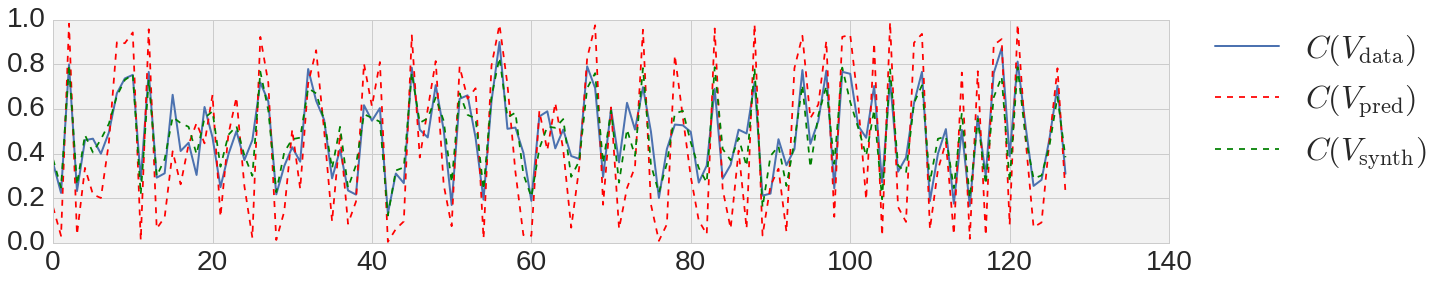

In [168]:
# Compare embedding of real data, predition and synthetic
test_enc_sub_data = enc_val(test_voxel_sub_data / scale)
test_enc_sub_pred = enc_val(test_voxel_sub_pred)
test_enc_synth_data=enc_synth(test_voxel_sub_pred)
print test_enc_sub_data.shape
plt.figure(figsize=(20,4))
for s in range(1):
    p=plt.plot(test_enc_sub_data[n+s,:], linestyle='-', lw=2, label=r'$C(V_\mathrm{data})$')
    plt.plot(test_enc_sub_pred[n+s,:], linestyle='--', color='r', label=r'$C(V_\mathrm{pred})$')
    plt.plot(test_enc_synth_data[n+s,:], linestyle='--', color='g' , label=r'$C(V_\mathrm{synth})$')
    plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0.)

(20, 128)


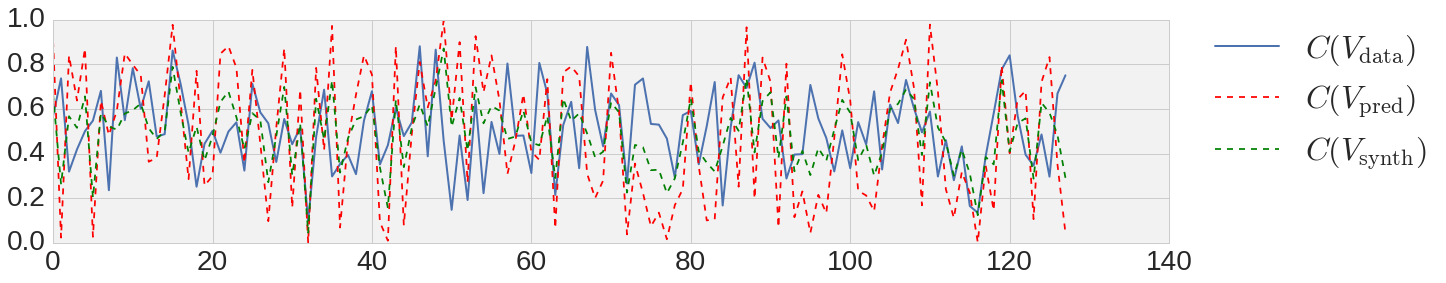

In [169]:
# Compare embedding of real data, predition and synthetic
test_enc_sub_data = enc_val(gen_voxel_sub_data / scale)
test_enc_sub_pred = enc_val(gen_voxel_sub_pred)
test_enc_synth_data=enc_synth(gen_voxel_sub_pred)
print test_enc_sub_data.shape
plt.figure(figsize=(20,4))
for s in range(1):
    p=plt.plot(test_enc_sub_data[n+s,:], linestyle='-', lw=2, label=r'$C(V_\mathrm{data})$')
    plt.plot(test_enc_sub_pred[n+s,:], linestyle='--', color='r', label=r'$C(V_\mathrm{pred})$')
    plt.plot(test_enc_synth_data[n+s,:], linestyle='--', color='g' , label=r'$C(V_\mathrm{synth})$')
    plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0.)

## Look at the embedding closeness

In [170]:
def cc_dist(a, b):
    l = len(a)
    cc = np.corrcoef(a, b)
    aa = cc[:l,:l] - np.identity(l) # zero-out the diagonal
    ab = np.diag(cc[l:,:l])
    bb = cc[l:,l:] - np.identity(l) # zero-out the diagonal
    return aa, ab, bb

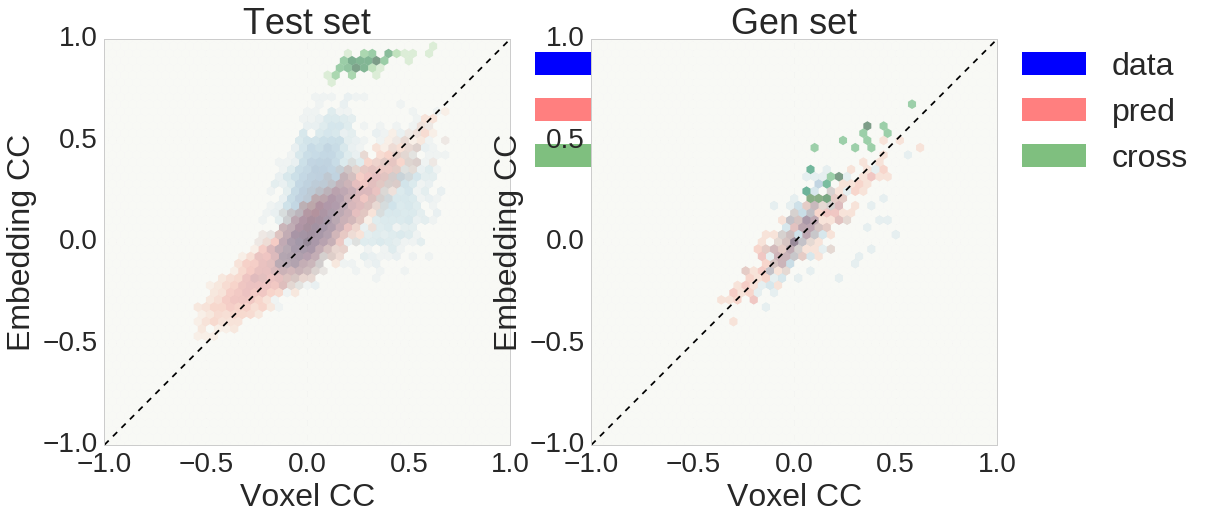

In [171]:
fig=plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
ddd,dpd,ppd = cc_dist(test_voxel_sub_data / scale, test_voxel_sub_pred)
dde,dpe,ppe = cc_dist(enc_val(test_voxel_sub_data / scale), enc_synth(test_voxel_sub_pred))
plt.hexbin(ddd.flatten(), dde.flatten(), linewidths=0, color='b', cmap='Blues',  gridsize=50, bins='log', alpha=1.0, extent=[-1, 1., -1, 1.], label='data')
plt.hexbin(ppd.flatten(), ppe.flatten(), linewidths=0, color='r', cmap='Reds',   gridsize=50, bins='log', alpha=0.5, extent=[-1, 1., -1, 1.], label='pred')
plt.hexbin(dpd.flatten(), dpe.flatten(), linewidths=0, color='g', cmap='Greens', gridsize=50, bins='log', alpha=0.5, extent=[-1, 1., -1, 1.], label='cross')
plt.plot([-1,1], [-1,1], '--k')
plt.gca().set_aspect('equal')
plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0.)
plt.xlabel('Voxel CC')
plt.ylabel('Embedding CC')
plt.title('Test set')
###
plt.subplot(1,2,2)
ddd,dpd,ppd = cc_dist(gen_voxel_sub_data / scale, gen_voxel_sub_pred)
dde,dpe,ppe = cc_dist(enc_val(gen_voxel_sub_data / scale), enc_synth(gen_voxel_sub_pred))
plt.hexbin(ddd.flatten(), dde.flatten(), linewidths=0, color='b', cmap='Blues',  gridsize=50, bins='log', alpha=1.0, extent=[-1, 1., -1, 1.], label='data')
plt.hexbin(ppd.flatten(), ppe.flatten(), linewidths=0, color='r', cmap='Reds',   gridsize=50, bins='log', alpha=0.5, extent=[-1, 1., -1, 1.], label='pred')
plt.hexbin(dpd.flatten(), dpe.flatten(), linewidths=0, color='g', cmap='Greens', gridsize=50, bins='log', alpha=0.5, extent=[-1, 1., -1, 1.], label='cross')
plt.plot([-1,1], [-1,1], '--k')
plt.gca().set_aspect('equal')
plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0.)
plt.xlabel('Voxel CC')
plt.ylabel('Embedding CC')
plt.title('Gen set')

In [172]:
def dist(a, b):
    return np.corrcoef(a, b)[len(a):,:len(b)]
def hits(a, b):
    dab = dist(a, b)
    daa = dist(a, a) - np.identity(len(a))
    hit = np.zeros(shape=(len(a)))
    for i in range(len(a)):
        hit[i] = np.sum((daa[i,:]<dab[i,i]).astype(int))
    return hit, dab, daa
        
print "Inferred:"
ha = hits(enc_val(test_voxel_sub_data / scale), enc_synth(test_voxel_sub_pred))
print "embedded hits = %f" % ( ha[0].mean() * 100 / len(ha[0]) )
hv = hits(test_voxel_sub_data / scale, test_voxel_sub_pred)
print "natural hits  = %f" % ( hv[0].mean() * 100 / len(hv[0]) )

print "Cross validated:"
ha = hits(enc_val(gen_voxel_sub_data / scale), enc_synth(gen_voxel_sub_pred))
print "embedded hits = %f" % ( ha[0].mean() * 100 / len(ha[0]) )
hv = hits(gen_voxel_sub_data / scale, gen_voxel_sub_pred)
print "natural hits  = %f" % ( hv[0].mean() * 100 / len(hv[0]) )

Inferred:
embedded hits = 100.000000
natural hits  = 91.460000
Cross validated:
embedded hits = 96.500000
natural hits  = 91.250000


## Generate a few sample of Vsynth for the same sample and display the signal-to-noise of the encoded condition vector

In [173]:
n=5
test_enc_sub_data = enc_val(test_voxel_sub_data[n:n+1] / scale)
rep = np.repeat(test_voxel_sub_pred[n:n+1], repeats=10000, axis=0)
Vemsynth = enc_synth(rep)

Vemsynth_avg = np.mean(Vemsynth, axis=0)
Vemsynth_std = np.std(Vemsynth, axis=0)

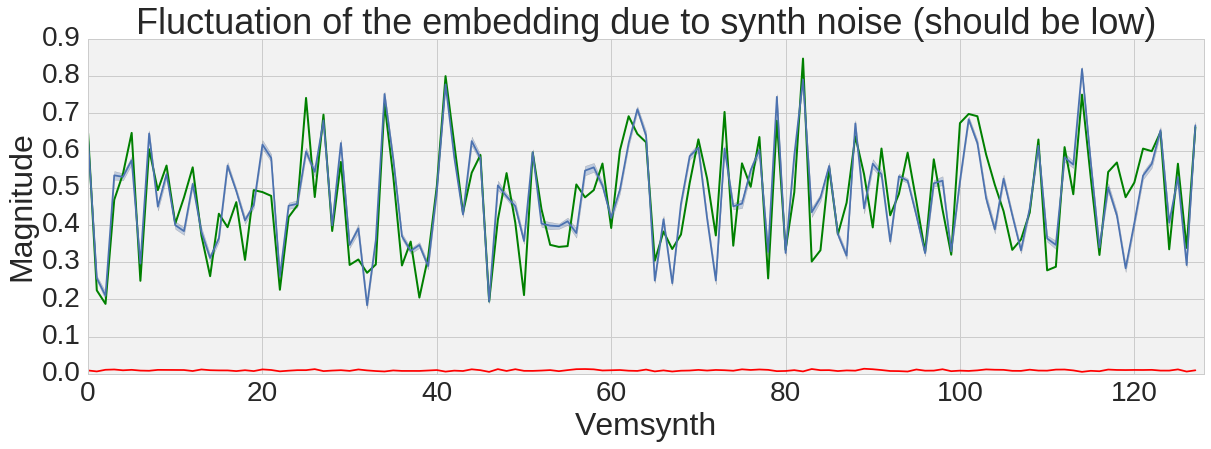

In [174]:
fig_3 = plt.figure(figsize=(20,6))
plt.plot(test_enc_sub_data[0], 'g', lw=2)
plt.plot(Vemsynth_avg)
plt.fill_between(np.arange(len(Vemsynth_avg)), Vemsynth_avg-Vemsynth_std, Vemsynth_avg+Vemsynth_std, alpha=0.3)
plt.plot(Vemsynth_std, 'r')
plt.xlim([0,len(test_enc_sub_data[0])])
plt.xlabel('Vemsynth')
plt.ylabel('Magnitude')
plt.title('Fluctuation of the embedding due to synth noise (should be low)')

In [175]:
Vemsynth_std_1 = np.copy(Vemsynth_std)
Vemsynth = enc_synth(test_voxel_sub_pred[:10000])
Vemsynth_avg = np.mean(Vemsynth, axis=0)
Vemsynth_std = np.std(Vemsynth, axis=0)

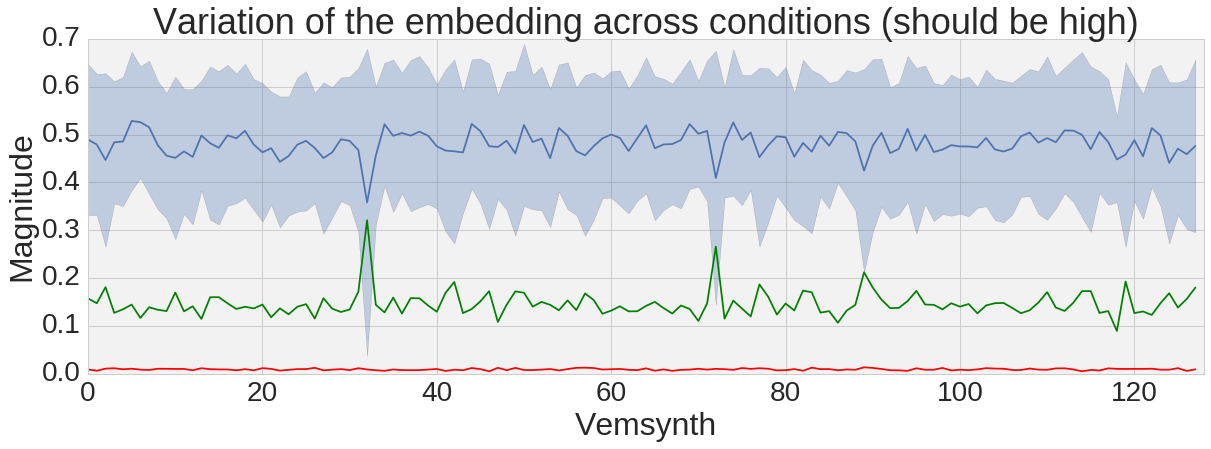

In [176]:
fig_4 = plt.figure(figsize=(20,6))
plt.plot(Vemsynth_avg)
plt.fill_between(np.arange(len(Vemsynth_avg)), Vemsynth_avg-Vemsynth_std, Vemsynth_avg+Vemsynth_std, alpha=0.3)

plt.plot(Vemsynth_std_1, 'r')
plt.plot(Vemsynth_std, 'g')

plt.xlim([0,len(test_enc_sub_data[0])])
plt.xlabel('Vemsynth')
plt.ylabel('Magnitude')

plt.title('Variation of the embedding across conditions (should be high)')

---

# Save the combined encoding and embedding with the noise model

In [177]:
auto_param_file_name = "cifar10-auto-linear-%s.pkl" % (timestamp)
auto_param_file = open(output_dir + auto_param_file_name, 'wb')
pickle.dump({'enc': L.get_all_param_values(_enc), 'dec': L.get_all_param_values(_dec), \
             'fwrf': {'val_cc': test_voxel_sub_cc, 'rf_params': voxelmodels_sub, 'w_params': voxelparams_sub, 'voxelavg': voxelavg_sub, 'voxelstd': voxelstd_sub},\
            'test': {'test_voxel_data': test_voxel_sub_data, 'test_stim_data': test_stim_data,\
                     'gen_voxel_data': gen_voxel_sub_data, 'gen_stim_data': gen_stim_data,\
                     'gen_voxel_pred': gen_voxel_sub_pred, 'test_voxel_pred': test_voxel_sub_pred},\
             'scale': scale,
             'voxel_cc':  test_voxel_sub_cc,
             'test_mask': test_mask,
             'noise_corr_matrix': test_noise_corr_matrix,\
            'mask': cc_mask},
            auto_param_file)
auto_param_file.close()
print auto_param_file_name

cifar10-auto-linear-Aug-19-2019_1823.pkl


---